In [ ]:
import numpy as np
import pandas as pd
import prophet
import matplotlib.pyplot as plt
import io
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
%pip install gurobipy>=10
import gurobipy as grb
from gurobipy import GRB
from google.colab import files
import math
import scipy.optimize as opt

##處理原始資料、進行預測與分析的程式碼：

In [ ]:
def moving_average(data, extra_period = 4, n = 3):
  datalen = len(data)
  data = np.append(data, [np.nan] * extra_period)

  fore = np.full(datalen + extra_period, np.nan)

  for t in range(n, datalen + 1):
    fore[t] = np.mean(data[t-n : t])

  # Forecast for all extra periods
  for t in range(datalen + 1, datalen + extra_period):
    if(t >= datalen + extra_period - 1):
      fore[t] = np.mean(fore[t-n : t])
    else:
      fore[t] = np.mean(data[t-n : datalen] + fore[datalen : t])

  # Return a dataframe from array data
  df = pd.DataFrame.from_dict({'Demand':data, 'Forecast':fore, 'Error':data-fore})

  return df

In [ ]:
def exp_smooth(data, extra_period = 4, alpha = 0.4):
  datalen = len(data)
  data = np.append(data, [np.nan] * extra_period)

  f = np.full(datalen + extra_period, np.nan)
  f[1] = data[0]

  for t in range(2, datalen + 1):
    f[t] = alpha * data[t-1] + (1 - alpha) * f[t-1]

  for t in range(datalen + 1, datalen + extra_period):
    f[t] = f[t-1]

  df = pd.DataFrame.from_dict({'Demand':data, 'Forecast':f, 'Error':data-f})

  return df

In [ ]:
def seasonal_ES(data, slen = 4, extra_periods = 4, alpha = 0.4, beta = 0.4):
  datalen = len(data)
  data = np.append(data, [np.nan] * extra_periods)

  f,E,S = np.full((3, datalen + extra_periods), np.nan)

  for i in range(slen):
    E[i] = data[:slen].mean()
    S[i] = data[i] - E[i]

  for t in range(slen, datalen):
    f[t] = E[t-1] + S[t-slen]
    E[t] = alpha * (data[t] - S[t-slen]) + (1 - alpha) * E[t-1]
    S[t] = beta * (data[t] - E[t]) + (1 - beta) * S[t-slen]

  for t in range(datalen, datalen + extra_periods):
    f[t] = E[datalen-1] + S[t-slen]

  df = pd.DataFrame.from_dict({'Demand':data, 'Forecast':f, 'Level':E, 'Season':S, 'Error':data-f})

  return df

In [ ]:
def holtWinter(data, slen = 4, extraP = 4, alpha = 0.3, beta = 0.4, gamma = 0.3):
  lenD = len(data)
  data = np.append(data, [np.nan]*extraP)
  forecast = np.full(lenD + extraP, np.nan)

  E,T,S = np.full((3,lenD+extraP),np.nan)

  for i in range(slen):
    E[i] = data[:slen].mean()
    T[i] = 0
    S[i] = data[i]-E[i]

  for i in range(slen,lenD):
    forecast[i] = E[i-1] + T[i-1] + S[i-slen]
    E[i] = alpha*(data[i]-S[i-slen]) + (1-alpha)*(E[i-1]+T[i-1])
    T[i] = beta*(E[i]-E[i-1]) + (1-beta)*T[i-1]
    S[i] = gamma*(data[i]-E[i]) + (1-gamma)*S[i-slen]

  for i in range(lenD,lenD+extraP):
    forecast[i] = E[lenD-1] + (i-lenD)*T[lenD-1] + S[i-slen]

  dataF = pd.DataFrame.from_dict({'Demand':data, 'Forecast':forecast, 'Level':E, 'Trend':T, 'Season':S, 'Error':data-forecast})
  return dataF

In [ ]:
def KPI(dataframe):
  MAE = dataframe['Error'].abs().mean()
  MSE = (dataframe['Error'] ** 2).mean()
  MAPE = (dataframe['Error'].abs() / dataframe['Demand']).mean()
  print('MAE: {:0.2f}'.format(MAE))
  print('MSE: {:0.2f}'.format(MSE))
  print('MAPE: {:0.2f}'.format(MAPE))

In [ ]:
def miqp(features, response, non_zero, verbose = False):
    assert isinstance(non_zero, (int, np.integer))
    regressor = grb.Model()
    samples, dim = features.shape
    assert samples == response.shape[0]
    assert non_zero <= dim
    regressor.params.NonConvex = 2

    # Append a column of ones to the feature matrix to account for the y-intercept
    X = np.concatenate([features, np.ones((samples, 1))], axis=1)

    # Decision variables
    norm_0 = regressor.addVar(lb=non_zero, ub=non_zero, name="norm")
    beta = regressor.addMVar((dim + 1,), lb=-GRB.INFINITY, name="beta")
    intercept = beta[dim] # Last decision variable captures the y-intercept

    regressor.setObjective(beta.T @ X.T @ X @ beta
                           - 2*response.T @ X @ beta
                           + np.dot(response, response), GRB.MINIMIZE)

    # Budget constraint based on the L0-norm
    regressor.addGenConstrNorm(norm_0, beta[:-1], which=0, name="budget")

    if not verbose:
        regressor.params.OutputFlag = 0
    regressor.params.timelimit = 60
    regressor.params.mipgap = 0.001
    regressor.optimize()

    coeff = np.array([beta[i].X for i in range(dim)])
    return intercept.X, coeff


def split_folds(features, response, train_mask):
    xtrain = features[train_mask,:]
    xtest = features[~train_mask,:]
    ytrain = response[train_mask]
    ytest = response[~train_mask]
    return xtrain, xtest, ytrain, ytest


def cross_validate(features, response, non_zero, folds, standardize, seed):
    if seed is not None:
        np.random.seed(seed)
    samples, dim = features.shape
    assert samples == response.shape[0]
    fold_size = int(np.ceil(samples / folds))
    # Randomly assign each sample to a fold
    shuffled = np.random.choice(samples, samples, replace=False)
    mse_cv = 0
    # Exclude folds from training, one at a time,
    #to get out-of-sample estimates of the MSE
    for fold in range(folds):
        idx = shuffled[fold * fold_size : min((fold + 1) * fold_size, samples)]
        train_mask = np.ones(samples, dtype=bool)
        train_mask[idx] = False
        xtrain, xtest, ytrain, ytest = split_folds(features, response, train_mask)
        if standardize:
            scaler = StandardScaler()
            scaler.fit(xtrain)
            xtrain = scaler.transform(xtrain)
            xtest = scaler.transform(xtest)
        intercept, beta = miqp(xtrain, ytrain, non_zero)
        ypred = np.dot(xtest, beta) + intercept
        mse_cv += mse(ytest, ypred) / folds
    # Report the average out-of-sample MSE
    return mse_cv


def L0_regression(features, response, folds = 5, standardize = False, seed = None):
    dim = features.shape[1]
    best_mse = np.inf
    best = 0
    # Grid search to find best number of features to consider
    for i in range(1, dim + 1):
        val = cross_validate(features, response, i, folds=folds, standardize=standardize, seed=seed)
        if val < best_mse:
            best_mse = val
            best = i
    if standardize:
        scaler = StandardScaler()
        scaler.fit(features)
        features = scaler.transform(features)
    intercept, beta = miqp(features, response, best)
    return intercept, beta

In [ ]:
#Product 1
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([2707,3446,3383,2582,3146,2502,2776,3396,2709,2782,3227,3453,3315,3437,3289,2751,3134,3187,3270,3304])
qtr = np.array([1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4])
gdp_factor = np.array([0.225,0.256,0.245,0.296,0.231,0.263,0.252,0.305,0.237,0.27,0.259,0.313,0.224,0.255,0.244,0.295,0.228,0.259,0.248,0.3])
cpi_factor = np.array([1.028,1.018,1.016,1.017,1.042,1.03,1.029,1.027,1.055,1.049,1.045,1.038,1.052,1.047,1.044,1.04,1.06,1.055,1.052,1.055])
cost = 600*cpi_factor
price = 720*cpi_factor

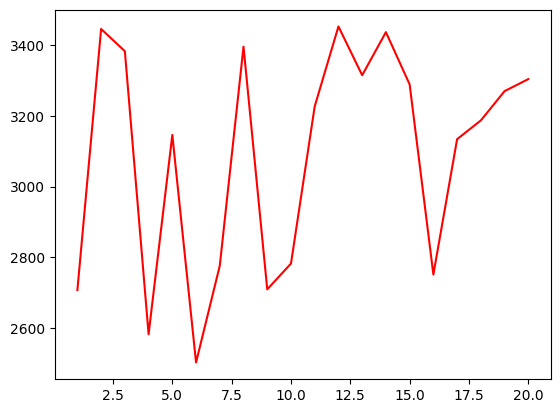

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig1.png')

In [ ]:
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_1 = sm.OLS(df[['Demand']], indep)
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9397
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.410
Time:                        12:37:59   Log-Likelihood:                -142.28
No. Observations:                  20   AIC:                             290.6
Df Residuals:                      17   BIC:                             293.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2971.9877    239.967     12.385      0.0

In [ ]:
dLasso = np.array([df['Period'], df['PeriodSqr'], qtr, gdp_factor, cpi_factor, cost, price])
lasso_1 = Lasso(alpha = 0.1, max_iter = 10000)
lasso_1.fit(dLasso.T, demand)
coeff = lasso_1.coef_
intercept = lasso_1.intercept_
print(coeff)
print(intercept)

fore_1 = lasso_1.predict(dLasso.T)
result_1_Lasso = pd.DataFrame.from_dict({'Demand':demand, 'Forecast':fore_1, 'Error': fore_1 - demand})
KPI(result_1_Lasso)

[ 5.12342482e+01 -2.93529462e-01 -2.51676329e+01 -1.57539687e+03
 -0.00000000e+00 -2.28751181e+01 -6.92664360e-02]
17392.12965929136
MAE: 246.09
MSE: 83264.34
MAPE: 0.08


In [ ]:
result_1_MA = moving_average(demand)
result_1_ES = exp_smooth(demand)
result_1_seasonES = seasonal_ES(demand)
result_1_HW = holtWinter(demand)

print(result_1_MA)
print(result_1_ES)
print(result_1_seasonES)
print(result_1_HW)

    Demand     Forecast       Error
0   2707.0          NaN         NaN
1   3446.0          NaN         NaN
2   3383.0          NaN         NaN
3   2582.0  3178.666667 -596.666667
4   3146.0  3137.000000    9.000000
5   2502.0  3037.000000 -535.000000
6   2776.0  2743.333333   32.666667
7   3396.0  2808.000000  588.000000
8   2709.0  2891.333333 -182.333333
9   2782.0  2960.333333 -178.333333
10  3227.0  2962.333333  264.666667
11  3453.0  2906.000000  547.000000
12  3315.0  3154.000000  161.000000
13  3437.0  3331.666667  105.333333
14  3289.0  3401.666667 -112.666667
15  2751.0  3347.000000 -596.000000
16  3134.0  3159.000000  -25.000000
17  3187.0  3058.000000  129.000000
18  3270.0  3024.000000  246.000000
19  3304.0  3197.000000  107.000000
20     NaN  3253.666667         NaN
21     NaN  6540.666667         NaN
22     NaN  8201.166667         NaN
23     NaN  5998.500000         NaN
    Demand     Forecast       Error
0   2707.0          NaN         NaN
1   3446.0  2707.000000  739

In [ ]:
print(KPI(result_1_MA))
print(KPI(result_1_ES))
print(KPI(result_1_seasonES))
print(KPI(result_1_HW))

MAE: 259.75
MSE: 112799.46
MAPE: 0.09
None
MAE: 295.87
MSE: 134606.54
MAPE: 0.10
None
MAE: 400.43
MSE: 276602.04
MAPE: 0.13
None
MAE: 421.89
MSE: 311124.85
MAPE: 0.14
None


In [ ]:
#Product 2
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand_J = np.array([1480,1370,1690,1720,1490,1460,1560,1670,1420,1450,1720,1680,1460,1630,1790,1730,1480,1470,1710,1720])
demand_S = np.array([1470,1360,1680,1710,1480,1450,1550,1660,1410,1440,1710,1670,1450,1620,1785,1726,1478,1460,1704,1718])
result_2_J = holtWinter(demand_J)
result_2_S = holtWinter(demand_S)

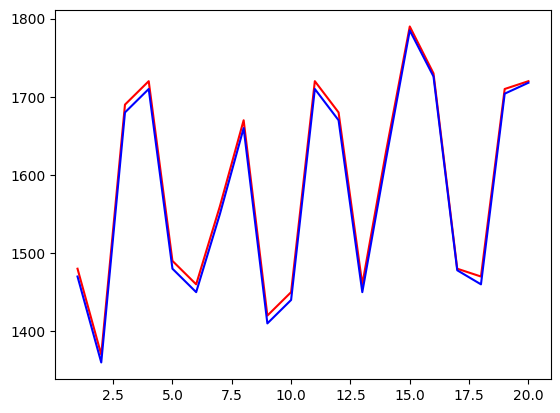

In [ ]:
plt.plot(period, demand_J, 'r')
plt.plot(period, demand_S, 'b')
plt.savefig('fig2.png')

In [ ]:
print(result_2_J)
print(result_2_S)

    Demand     Forecast        Level      Trend      Season       Error
0   1480.0          NaN  1565.000000   0.000000  -85.000000         NaN
1   1370.0          NaN  1565.000000   0.000000 -195.000000         NaN
2   1690.0          NaN  1565.000000   0.000000  125.000000         NaN
3   1720.0          NaN  1565.000000   0.000000  155.000000         NaN
4   1490.0  1480.000000  1568.000000   1.200000  -82.900000   10.000000
5   1460.0  1374.200000  1594.940000  11.496000 -176.982000   85.800000
6   1560.0  1731.436000  1555.005200  -9.076320   88.998440 -171.436000
7   1670.0  1700.928880  1536.650216 -12.787786  148.504935  -30.928880
8   1420.0  1440.962430  1517.573701 -15.303277  -87.302110  -20.962430
9   1450.0  1325.288424  1539.683897  -0.337888 -150.792569  124.711576
10  1720.0  1628.344449  1566.842674  10.660778  108.246106   91.655551
11  1680.0  1726.008387  1563.700936   5.139772  138.843174  -46.008387
12  1460.0  1481.538597  1562.379128   2.555140  -91.825216  -21

In [ ]:
print(KPI(result_2_J))
print(KPI(result_2_S))

MAE: 73.52
MSE: 8927.98
MAPE: 0.05
None
MAE: 73.83
MSE: 8924.58
MAPE: 0.05
None


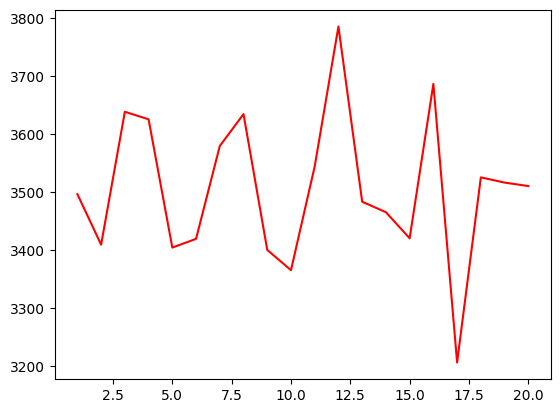

In [ ]:
#Product 3
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([3496,3409,3638,3625,3404,3419,3579,3634,3400,3365,3544,3785,3483,3465,3420,3686,3206,3525,3516,3510])
result_3 = holtWinter(demand)
plt.plot(period, demand, 'r')
plt.savefig('fig3.png')

In [ ]:
print(result_3)

    Demand     Forecast        Level      Trend      Season       Error
0   3496.0          NaN  3542.000000   0.000000  -46.000000         NaN
1   3409.0          NaN  3542.000000   0.000000 -133.000000         NaN
2   3638.0          NaN  3542.000000   0.000000   96.000000         NaN
3   3625.0          NaN  3542.000000   0.000000   83.000000         NaN
4   3404.0  3496.000000  3514.400000 -11.040000  -65.320000  -92.000000
5   3419.0  3370.360000  3517.952000  -5.203200 -122.785600   48.640000
6   3579.0  3608.748800  3503.824160  -8.773056   89.752752  -29.748800
7   3634.0  3578.051104  3511.835773  -2.059188   94.749268   55.948896
8   3400.0  3444.456584  3496.439609  -7.393979  -74.655883  -44.456584
9   3365.0  3366.260030  3488.667621  -7.545182 -123.050206   -1.260030
10  3544.0  3570.875191  3473.059882 -10.770205   84.108962  -26.875191
11  3785.0  3557.038945  3530.677993  16.585121  142.621090  227.961055
12  3483.0  3472.607232  3550.380945  17.832254  -72.473401   10

In [ ]:
print(KPI(result_3))

MAE: 90.56
MSE: 16330.92
MAPE: 0.03
None


In [ ]:
#Product 4
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([2132,2413,2462,2310,2348,2337,2274,2382,2018,2026,2240,2078,2014,2175,2314,2419,2034,2070,2228,2312])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_4 = sm.OLS(df[['Demand']], indep)
result_4 = model_4.fit()

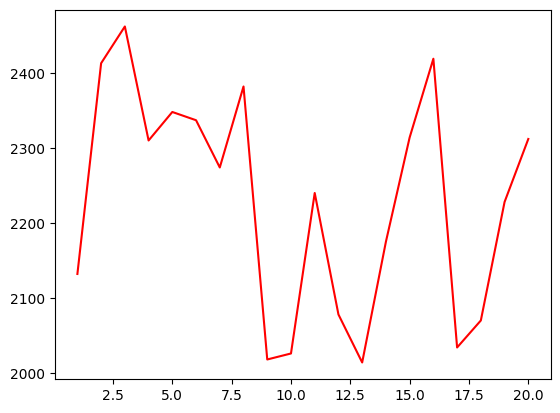

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig4.png')

In [ ]:
print(result_4.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     1.773
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.200
Time:                        12:38:00   Log-Likelihood:                -126.16
No. Observations:                  20   AIC:                             258.3
Df Residuals:                      17   BIC:                             261.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2415.1088    107.214     22.526      0.0

In [ ]:
#Product 5
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand_S = np.array([1638,1628,1966,1634,1796,1793,1944,1690,1670,1624,1824,1648,1740,1818,1950,1734,1794,1640,1953,1974])
demand_A = np.array([2456,2441,2949,2450,2694,2700,2916,2559,2510,2435,2785,2465,2650,2752,2941,2610,2691,2460,2930,2961])
result_5_S = holtWinter(demand_S)
result_5_A = holtWinter(demand_A)

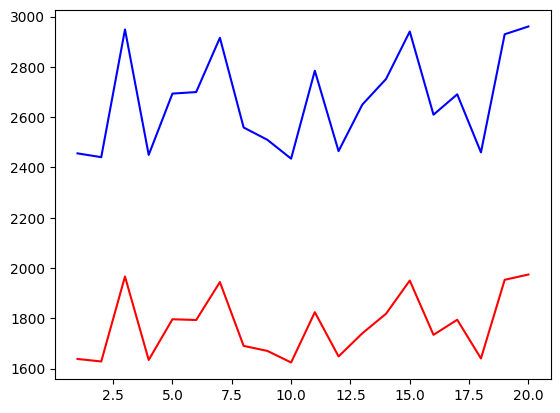

In [ ]:
plt.plot(period, demand_S, 'r')
plt.plot(period, demand_A, 'b')
plt.savefig('fig5.png')

In [ ]:
print(result_5_S)
print(result_5_A)

    Demand     Forecast        Level      Trend      Season       Error
0   1638.0          NaN  1716.500000   0.000000  -78.500000         NaN
1   1628.0          NaN  1716.500000   0.000000  -88.500000         NaN
2   1966.0          NaN  1716.500000   0.000000  249.500000         NaN
3   1634.0          NaN  1716.500000   0.000000  -82.500000         NaN
4   1796.0  1638.000000  1763.900000  18.960000  -45.320000  158.000000
5   1793.0  1694.360000  1812.452000  30.796800  -67.785600   98.640000
6   1944.0  2092.748800  1798.624160  12.946944  218.262752 -148.748800
7   1690.0  1729.071104  1799.849773   8.258412  -90.704932  -39.071104
8   1670.0  1762.788184  1780.271729  -2.876171  -64.805519  -92.788184
9   1624.0  1709.609958  1751.712571 -13.149366  -85.763691  -85.609958
10  1824.0  1956.825957  1698.715418 -29.088480  190.369301 -132.825957
11  1648.0  1578.922006  1690.350336 -20.799121  -76.198553   69.077994
12  1740.0  1604.745696  1710.127506  -4.568605  -36.402115  135

In [ ]:
print(KPI(result_5_S))
print(KPI(result_5_A))

MAE: 103.71
MSE: 15574.97
MAPE: 0.06
None
MAE: 154.71
MSE: 35956.85
MAPE: 0.06
None


In [ ]:
#Product 6
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([6246,6286,6327,6313,6410,6462,6670,6273,6323,6384,6610,6553,6285,6361,6647,6129,6239,6318,6473,6392])
result_6 = holtWinter(demand)

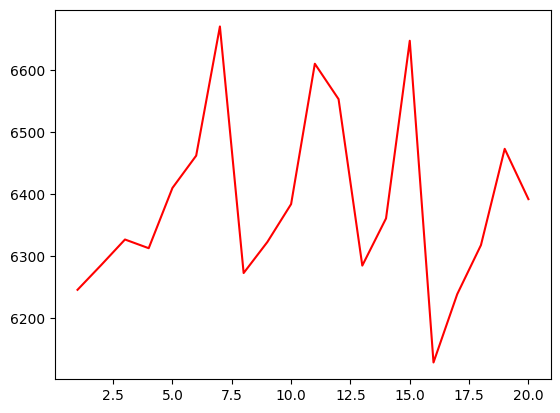

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig6.png')

In [ ]:
print(result_6)

    Demand     Forecast        Level      Trend      Season       Error
0   6246.0          NaN  6293.000000   0.000000  -47.000000         NaN
1   6286.0          NaN  6293.000000   0.000000   -7.000000         NaN
2   6327.0          NaN  6293.000000   0.000000   34.000000         NaN
3   6313.0          NaN  6293.000000   0.000000   20.000000         NaN
4   6410.0  6246.000000  6342.200000  19.680000  -12.560000  164.000000
5   6462.0  6354.880000  6394.016000  32.534400   15.495200  107.120000
6   6670.0  6460.550400  6489.385280  57.668352   77.984416  209.449600
7   6273.0  6567.053632  6458.837542  22.381916  -41.751263 -294.053632
8   6323.0  6468.659459  6437.521621   4.902781  -43.148486 -145.659459
9   6384.0  6457.919602  6420.248521  -3.967571   -0.027916  -73.919602
10  6610.0  6494.265366  6451.001340   9.920585  102.288689  115.734634
11  6553.0  6419.170663  6501.070727  25.980105  -13.647102  133.829337
12  6285.0  6483.902346  6467.380128   2.111824  -84.917979 -198

In [ ]:
print(KPI(result_6))

MAE: 144.69
MSE: 27642.27
MAPE: 0.02
None


In [ ]:
#Product 7
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([5091,5260,5280,5290,5334,5343,5520,5661,5709,5766,5805,5806,6093,6098,6126,6374,6509,6788,6896,6978])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_7 = sm.OLS(df[['Demand']], indep)
result_7 = model_7.fit()

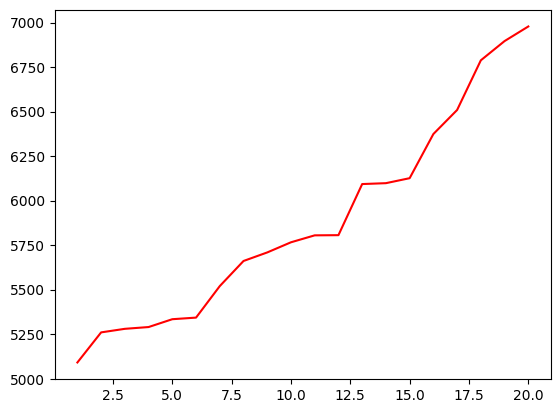

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig7.png')

In [ ]:
print(result_7.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     569.8
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           2.64e-16
Time:                        12:38:01   Log-Likelihood:                -112.92
No. Observations:                  20   AIC:                             231.8
Df Residuals:                      17   BIC:                             234.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5151.8237     55.286     93.185      0.0

In [ ]:
#Product 8
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([8336,9113,8812,8387,8684,9015,8888,8244,8672,9052,8913,8177,8331,9123,8741,8499,8297,9164,8942,8192])
result_8 = holtWinter(demand)

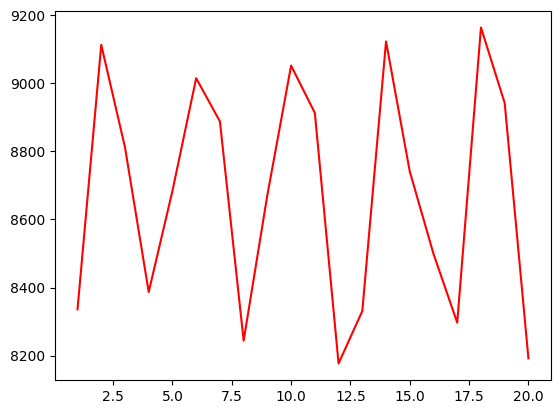

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig8.png')

In [ ]:
print(result_8)

    Demand     Forecast        Level      Trend      Season       Error
0   8336.0          NaN  8662.000000   0.000000 -326.000000         NaN
1   9113.0          NaN  8662.000000   0.000000  451.000000         NaN
2   8812.0          NaN  8662.000000   0.000000  150.000000         NaN
3   8387.0          NaN  8662.000000   0.000000 -275.000000         NaN
4   8684.0  8336.000000  8766.400000  41.760000 -252.920000  348.000000
5   9015.0  9259.160000  8734.912000  12.460800  399.726400 -244.160000
6   8888.0  8897.372800  8744.560960  11.336064  148.031712   -9.372800
7   8244.0  8480.897024  8684.827917 -17.091579 -324.748375 -236.897024
8   8672.0  8414.816338  8744.891437  13.770461 -198.911431  257.183662
9   9052.0  9158.388297  8726.745408   1.003865  377.384858 -106.388297
10  8913.0  8875.780985  8738.914977   5.470147  155.847705   37.219015
11  8177.0  8419.636749  8671.594099 -23.646263 -375.702092 -242.636749
12  8331.0  8449.036405  8612.536915 -37.810632 -223.699076 -118

In [ ]:
print(KPI(result_8))

MAE: 169.64
MSE: 38173.82
MAPE: 0.02
None


In [ ]:
#Product 9
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([5184,6971,6951,6583,5305,6499,6847,6717,5048,6180,6329,5987,6536,6535,5274,6298,9794,6201,6504,5674])
gdp_factor = np.array([0.225,0.256,0.245,0.296,0.231,0.263,0.252,0.305,0.237,0.27,0.259,0.313,0.224,0.255,0.244,0.295,0.228,0.259,0.248,0.3])
cpi_factor = np.array([1.028,1.018,1.016,1.017,1.042,1.03,1.029,1.027,1.055,1.049,1.045,1.038,1.052,1.047,1.044,1.04,1.06,1.055,1.052,1.055])
cost = 450*cpi_factor
price = 540*cpi_factor

df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand, 'Cost':cost, 'Price':price, 'GDP_Factor':gdp_factor})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_9 = sm.OLS(df[['Demand']], indep)
result_9 = model_9.fit()

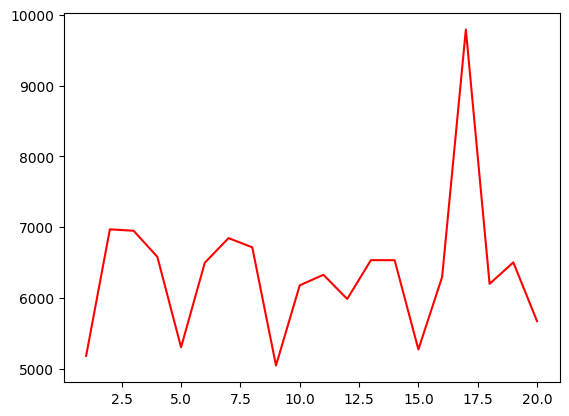

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig9.png')

In [ ]:
print(result_9.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.095
Method:                 Least Squares   F-statistic:                    0.1751
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.841
Time:                        12:38:02   Log-Likelihood:                -165.87
No. Observations:                  20   AIC:                             337.7
Df Residuals:                      17   BIC:                             340.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6176.8886    780.545      7.914      0.0

In [ ]:
dLasso = np.array([df['Period'], df['PeriodSqr'], qtr, gdp_factor, cpi_factor, cost, price])
lasso_9 = Lasso(alpha = 0.1, max_iter = 10000)
lasso_9.fit(dLasso.T, demand)
coeff = lasso_1.coef_
intercept = lasso_1.intercept_
print(coeff)
print(intercept)

fore_9 = lasso_9.predict(dLasso.T)
result_9_Lasso = pd.DataFrame.from_dict({'Demand':demand, 'Forecast':fore_9, 'Error': fore_9 - demand})
KPI(result_1_Lasso)

[ 5.12342482e+01 -2.93529462e-01 -2.51676329e+01 -1.57539687e+03
 -0.00000000e+00 -2.28751181e+01 -6.92664360e-02]
17392.12965929136
MAE: 246.09
MSE: 83264.34
MAPE: 0.08


In [ ]:
result_9_MA = moving_average(demand)
result_9_ES = exp_smooth(demand)
result_9_seasonES = seasonal_ES(demand)
result_9_HW = holtWinter(demand)

print(result_9_MA)
print(result_9_ES)
print(result_9_seasonES)
print(result_9_HW)

    Demand      Forecast        Error
0   5184.0           NaN          NaN
1   6971.0           NaN          NaN
2   6951.0           NaN          NaN
3   6583.0   6368.666667   214.333333
4   5305.0   6835.000000 -1530.000000
5   6499.0   6279.666667   219.333333
6   6847.0   6129.000000   718.000000
7   6717.0   6217.000000   500.000000
8   5048.0   6687.666667 -1639.666667
9   6180.0   6204.000000   -24.000000
10  6329.0   5981.666667   347.333333
11  5987.0   5852.333333   134.666667
12  6536.0   6165.333333   370.666667
13  6535.0   6284.000000   251.000000
14  5274.0   6352.666667 -1078.666667
15  6298.0   6115.000000   183.000000
16  9794.0   6035.666667  3758.333333
17  6201.0   7122.000000  -921.000000
18  6504.0   7431.000000  -927.000000
19  5674.0   7499.666667 -1825.666667
20     NaN   6126.333333          NaN
21     NaN  12215.333333          NaN
22     NaN  14844.833333          NaN
23     NaN  11062.166667          NaN
    Demand     Forecast        Error
0   5184.0   

In [ ]:
print(KPI(result_9_MA))
print(KPI(result_9_ES))
print(KPI(result_9_seasonES))
print(KPI(result_9_HW))

MAE: 861.33
MSE: 1564201.88
MAPE: 0.13
None
MAE: 882.92
MSE: 1456793.02
MAPE: 0.13
None
MAE: 935.18
MSE: 2163898.66
MAPE: 0.14
None
MAE: 984.49
MSE: 2404917.12
MAPE: 0.14
None


In [ ]:
from pandas.core.indexes.datetimes import periods_per_day
#Product 10
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([9640,10141,9852,10607,10931,10254,10990,10470,10996,10850,10523,11273,12723,11012,9745,9414,10208,10140,11478,13540])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_10 = sm.OLS(df[['Demand']], indep)
result_10 = model_10.fit()

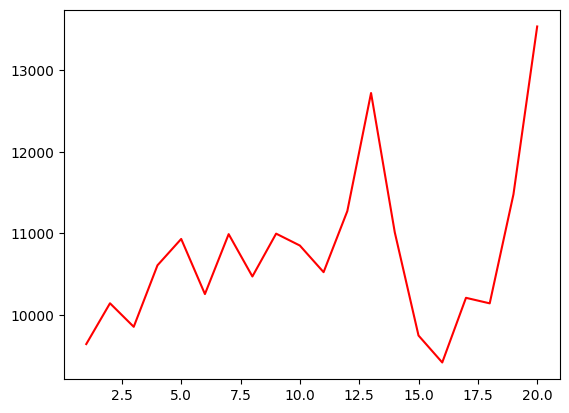

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig10.png')

In [ ]:
print(result_10.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.486
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.254
Time:                        12:38:02   Log-Likelihood:                -164.40
No. Observations:                  20   AIC:                             334.8
Df Residuals:                      17   BIC:                             337.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+04    725.170     13.907      0.0

In [ ]:
result_10_MA = moving_average(demand)
result_10_ES = exp_smooth(demand)
result_10_seasonES = seasonal_ES(demand)
result_10_HW = holtWinter(demand)

print(result_10_MA)
print(result_10_ES)
print(result_10_seasonES)
print(result_10_HW)

     Demand      Forecast        Error
0    9640.0           NaN          NaN
1   10141.0           NaN          NaN
2    9852.0           NaN          NaN
3   10607.0   9877.666667   729.333333
4   10931.0  10200.000000   731.000000
5   10254.0  10463.333333  -209.333333
6   10990.0  10597.333333   392.666667
7   10470.0  10725.000000  -255.000000
8   10996.0  10571.333333   424.666667
9   10850.0  10818.666667    31.333333
10  10523.0  10772.000000  -249.000000
11  11273.0  10789.666667   483.333333
12  12723.0  10882.000000  1841.000000
13  11012.0  11506.333333  -494.333333
14   9745.0  11669.333333 -1924.333333
15   9414.0  11160.000000 -1746.000000
16  10208.0  10057.000000   151.000000
17  10140.0   9789.000000   351.000000
18  11478.0   9920.666667  1557.333333
19  13540.0  10608.666667  2931.333333
20      NaN  11719.333333          NaN
21      NaN  24228.333333          NaN
22      NaN  31513.833333          NaN
23      NaN  22487.166667          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_10_MA))
print(KPI(result_10_ES))
print(KPI(result_10_seasonES))
print(KPI(result_10_HW))

MAE: 853.06
MSE: 1373851.87
MAPE: 0.08
None
MAE: 738.59
MSE: 1071535.59
MAPE: 0.07
None
MAE: 973.62
MSE: 1506070.80
MAPE: 0.09
None
MAE: 1075.47
MSE: 1965682.57
MAPE: 0.10
None


In [ ]:
#Product 11
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([24400,19200,18400,28600,25200,18500,18700,29400,26900,16900,18700,27500,24100,18500,19300,25600,29800,21200,20500,30100])
result_11 = holtWinter(demand)

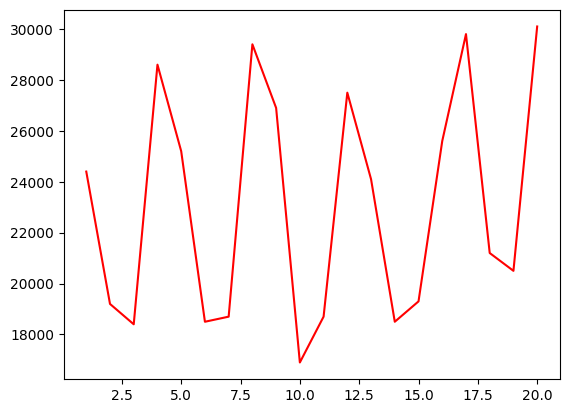

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig11.png')

In [ ]:
print(result_11)

     Demand      Forecast         Level       Trend       Season        Error
0   24400.0           NaN  22650.000000    0.000000  1750.000000          NaN
1   19200.0           NaN  22650.000000    0.000000 -3450.000000          NaN
2   18400.0           NaN  22650.000000    0.000000 -4250.000000          NaN
3   28600.0           NaN  22650.000000    0.000000  5950.000000          NaN
4   25200.0  24400.000000  22890.000000   96.000000  1918.000000   800.000000
5   18500.0  19536.000000  22675.200000  -28.320000 -3667.560000 -1036.000000
6   18700.0  18396.880000  22737.816000    8.054400 -4186.344800   303.120000
7   29400.0  28695.870400  22957.109280   92.549952  6097.867216   704.129600
8   26900.0  24967.659232  23629.361462  324.430844  2323.791561  1932.340768
9   16900.0  20286.232307  22937.922615  -81.917033 -4378.668784 -3386.232307
10  18700.0  18669.660782  22865.107347  -78.276326 -4179.973564    30.339218
11  27500.0  28884.698237  22371.421550 -244.440115  5807.080586

In [ ]:
print(KPI(result_11))

MAE: 1502.82
MSE: 4482637.12
MAPE: 0.06
None


In [ ]:
#Product 12
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([12000,7000,11000,14000,11500,7400,10400,14600,13500,8600,10500,18500,12300,7900,10900,15400,12100,6900,9900,11100])
result_12 = holtWinter(demand)

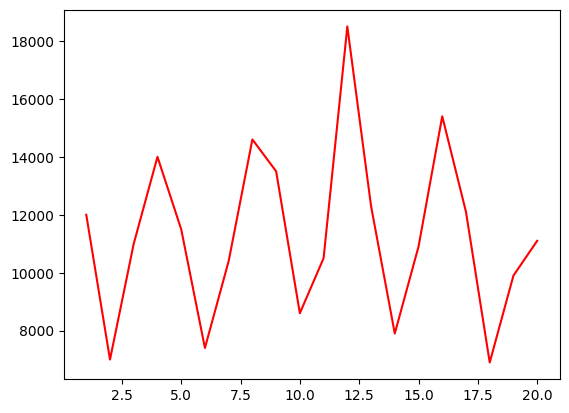

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig12.png')

In [ ]:
print(result_12)

     Demand      Forecast         Level       Trend       Season        Error
0   12000.0           NaN  11000.000000    0.000000  1000.000000          NaN
1    7000.0           NaN  11000.000000    0.000000 -4000.000000          NaN
2   11000.0           NaN  11000.000000    0.000000     0.000000          NaN
3   14000.0           NaN  11000.000000    0.000000  3000.000000          NaN
4   11500.0  12000.000000  10850.000000  -60.000000   895.000000  -500.000000
5    7400.0   6790.000000  10973.000000   13.200000 -3871.900000   610.000000
6   10400.0  10986.200000  10810.340000  -57.144000  -123.102000  -586.200000
7   14600.0  13753.196000  11007.237200   44.472480  3177.828840   846.804000
8   13500.0  11946.709680  11517.696776  230.867318  1221.190967  1553.290320
9    8600.0   7876.664094  11965.564866  317.667627 -3719.999460   723.335906
10  10500.0  12160.130493  11785.193345  118.451968  -471.729404 -1660.130493
11  18500.0  15081.474153  12929.203067  528.675070  3895.719268

In [ ]:
print(KPI(result_12))

MAE: 1266.90
MSE: 2491912.16
MAPE: 0.11
None


In [ ]:
#Product 13
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([8000,25000,15000,17000,9500,23500,18700,19400,7100,25300,14800,16300,8200,21500,13200,20100,9800,27900,16200,23300])
result_13 = holtWinter(demand)

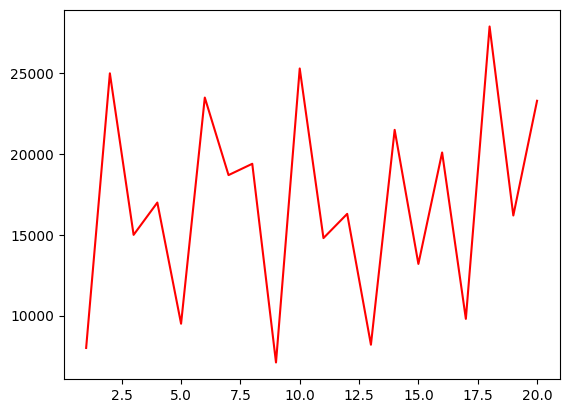

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig13.png')

In [ ]:
print(result_13)

     Demand      Forecast         Level       Trend       Season        Error
0    8000.0           NaN  16250.000000    0.000000 -8250.000000          NaN
1   25000.0           NaN  16250.000000    0.000000  8750.000000          NaN
2   15000.0           NaN  16250.000000    0.000000 -1250.000000          NaN
3   17000.0           NaN  16250.000000    0.000000   750.000000          NaN
4    9500.0   8000.000000  16700.000000  180.000000 -7935.000000  1500.000000
5   23500.0  25630.000000  16241.000000  -75.600000  8302.700000 -2130.000000
6   18700.0  14915.400000  17300.780000  378.552000  -455.234000  3784.600000
7   19400.0  18429.332000  17970.532400  495.032160   953.840280   970.668000
8    7100.0  10530.564560  17436.395192   83.364413 -8655.418558 -3430.564560
9   25300.0  25822.459605  17363.021723   20.669260  8192.983483  -522.459605
10  14800.0  16928.456984  16745.153889 -234.745578  -902.209967 -2128.456984
11  16300.0  17464.248591  16161.133733 -374.455409   709.348076

In [ ]:
print(KPI(result_13))

MAE: 2217.20
MSE: 6704870.60
MAPE: 0.15
None


In [ ]:
#Product 14
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([22500,22600,23800,26800,26000,19000,25200,26900,23700,17800,23200,18100,21600,29600,26400,19800,27400,19500,20800,18900])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_14 = sm.OLS(df[['Demand']], indep)
result_14 = model_14.fit()

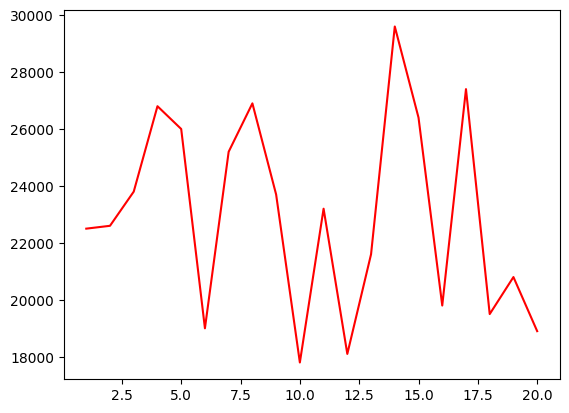

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig14.png')

In [ ]:
print(result_14.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.5985
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.561
Time:                        12:38:04   Log-Likelihood:                -190.39
No. Observations:                  20   AIC:                             386.8
Df Residuals:                      17   BIC:                             389.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.296e+04   2660.431      8.630      0.0

In [ ]:
result_14_MA = moving_average(demand)
result_14_ES = exp_smooth(demand)
result_14_seasonES = seasonal_ES(demand)
result_14_HW = holtWinter(demand)

print(result_14_MA)
print(result_14_ES)
print(result_14_seasonES)
print(result_14_HW)

     Demand      Forecast        Error
0   22500.0           NaN          NaN
1   22600.0           NaN          NaN
2   23800.0           NaN          NaN
3   26800.0  22966.666667  3833.333333
4   26000.0  24400.000000  1600.000000
5   19000.0  25533.333333 -6533.333333
6   25200.0  23933.333333  1266.666667
7   26900.0  23400.000000  3500.000000
8   23700.0  23700.000000     0.000000
9   17800.0  25266.666667 -7466.666667
10  23200.0  22800.000000   400.000000
11  18100.0  21566.666667 -3466.666667
12  21600.0  19700.000000  1900.000000
13  29600.0  20966.666667  8633.333333
14  26400.0  23100.000000  3300.000000
15  19800.0  25866.666667 -6066.666667
16  27400.0  25266.666667  2133.333333
17  19500.0  24533.333333 -5033.333333
18  20800.0  22233.333333 -1433.333333
19  18900.0  22566.666667 -3666.666667
20      NaN  19733.333333          NaN
21      NaN  39583.333333          NaN
22      NaN  48558.333333          NaN
23      NaN  35958.333333          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_14_MA))
print(KPI(result_14_ES))
print(KPI(result_14_seasonES))
print(KPI(result_14_HW))

MAE: 3543.14
MSE: 18408562.09
MAPE: 0.16
None
MAE: 3339.91
MSE: 16070864.16
MAPE: 0.15
None
MAE: 3651.48
MSE: 23330444.29
MAPE: 0.17
None
MAE: 4029.36
MSE: 26941046.40
MAPE: 0.18
None


In [ ]:
#Product 15
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([23800,24000,21800,22500,24100,20900,23100,21800,21300,21900,20500,20100,22100,20700,24800,23800,24100,22500,22400,20600])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_15 = sm.OLS(df[['Demand']], indep)
result_15 = model_15.fit()

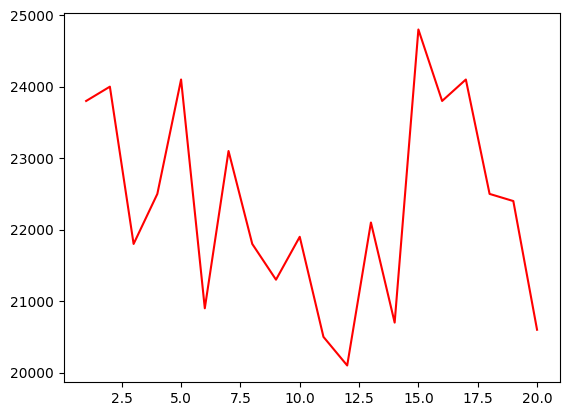

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig15.png')

In [ ]:
print(result_15.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.119
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.350
Time:                        12:38:04   Log-Likelihood:                -171.72
No. Observations:                  20   AIC:                             349.4
Df Residuals:                      17   BIC:                             352.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.381e+04   1045.758     22.766      0.0

In [ ]:
result_15_MA = moving_average(demand)
result_15_ES = exp_smooth(demand)
result_15_seasonES = seasonal_ES(demand)
result_15_HW = holtWinter(demand)

print(result_15_MA)
print(result_15_ES)
print(result_15_seasonES)
print(result_15_HW)

     Demand      Forecast        Error
0   23800.0           NaN          NaN
1   24000.0           NaN          NaN
2   21800.0           NaN          NaN
3   22500.0  23200.000000  -700.000000
4   24100.0  22766.666667  1333.333333
5   20900.0  22800.000000 -1900.000000
6   23100.0  22500.000000   600.000000
7   21800.0  22700.000000  -900.000000
8   21300.0  21933.333333  -633.333333
9   21900.0  22066.666667  -166.666667
10  20500.0  21666.666667 -1166.666667
11  20100.0  21233.333333 -1133.333333
12  22100.0  20833.333333  1266.666667
13  20700.0  20900.000000  -200.000000
14  24800.0  20966.666667  3833.333333
15  23800.0  22533.333333  1266.666667
16  24100.0  23100.000000  1000.000000
17  22500.0  24233.333333 -1733.333333
18  22400.0  23466.666667 -1066.666667
19  20600.0  23000.000000 -2400.000000
20      NaN  21833.333333          NaN
21      NaN  43333.333333          NaN
22      NaN  53183.333333          NaN
23      NaN  39450.000000          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_15_MA))
print(KPI(result_15_ES))
print(KPI(result_15_seasonES))
print(KPI(result_15_HW))

MAE: 1252.94
MSE: 2292222.22
MAPE: 0.06
None
MAE: 1239.82
MSE: 2248439.57
MAPE: 0.06
None
MAE: 1363.77
MSE: 3280052.49
MAPE: 0.06
None
MAE: 1504.63
MSE: 4271038.79
MAPE: 0.07
None


In [ ]:
#Product 16
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([29200,30700,29900,31600,29300,28700,30600,31300,30200,31700,29000,30300,31700,28200,27300,29400,29800,29200,27100,30100])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_16 = sm.OLS(df[['Demand']], indep)
result_16 = model_16.fit()

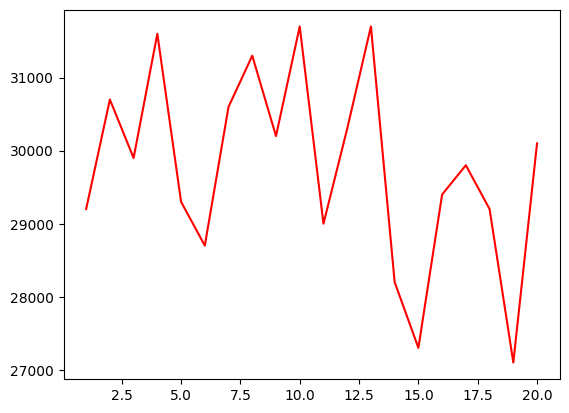

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig16.png')

In [ ]:
print(result_16.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1.829
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.191
Time:                        12:38:05   Log-Likelihood:                -169.81
No. Observations:                  20   AIC:                             345.6
Df Residuals:                      17   BIC:                             348.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.985e+04    950.614     31.403      0.0

In [ ]:
result_16_MA = moving_average(demand)
result_16_ES = exp_smooth(demand)
result_16_seasonES = seasonal_ES(demand)
result_16_HW = holtWinter(demand)

print(result_16_MA)
print(result_16_ES)
print(result_16_seasonES)
print(result_16_HW)

     Demand      Forecast        Error
0   29200.0           NaN          NaN
1   30700.0           NaN          NaN
2   29900.0           NaN          NaN
3   31600.0  29933.333333  1666.666667
4   29300.0  30733.333333 -1433.333333
5   28700.0  30266.666667 -1566.666667
6   30600.0  29866.666667   733.333333
7   31300.0  29533.333333  1766.666667
8   30200.0  30200.000000     0.000000
9   31700.0  30700.000000  1000.000000
10  29000.0  31066.666667 -2066.666667
11  30300.0  30300.000000     0.000000
12  31700.0  30333.333333  1366.666667
13  28200.0  30333.333333 -2133.333333
14  27300.0  30066.666667 -2766.666667
15  29400.0  29066.666667   333.333333
16  29800.0  28300.000000  1500.000000
17  29200.0  28833.333333   366.666667
18  27100.0  29466.666667 -2366.666667
19  30100.0  28700.000000  1400.000000
20      NaN  28800.000000          NaN
21      NaN  57400.000000          NaN
22      NaN  73200.000000          NaN
23      NaN  53133.333333          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_16_MA))
print(KPI(result_16_ES))
print(KPI(result_16_seasonES))
print(KPI(result_16_HW))

MAE: 1321.57
MSE: 2373333.33
MAPE: 0.05
None
MAE: 1265.19
MSE: 2154510.01
MAPE: 0.04
None
MAE: 1296.78
MSE: 2362242.81
MAPE: 0.04
None
MAE: 1394.71
MSE: 2590273.11
MAPE: 0.05
None


In [ ]:
#Product 17
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([38900,34500,36500,38800,36600,37300,38100,35800,35200,37400,38700,35400,38300,35000,37200,38600,37400,32300,35800,36200])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_17 = sm.OLS(df[['Demand']], indep)
result_17 = model_17.fit()

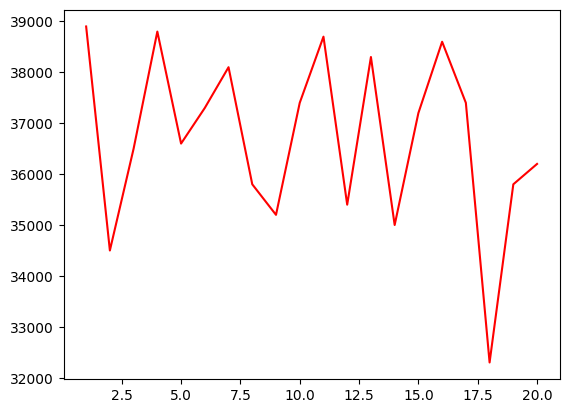

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig17.png')

In [ ]:
print(result_17.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.7640
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.481
Time:                        12:38:05   Log-Likelihood:                -175.96
No. Observations:                  20   AIC:                             357.9
Df Residuals:                      17   BIC:                             360.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.685e+04   1292.502     28.512      0.0

In [ ]:
result_17_MA = moving_average(demand)
result_17_ES = exp_smooth(demand)
result_17_seasonES = seasonal_ES(demand)
result_17_HW = holtWinter(demand)

print(result_17_MA)
print(result_17_ES)
print(result_17_seasonES)
print(result_17_HW)

     Demand      Forecast        Error
0   38900.0           NaN          NaN
1   34500.0           NaN          NaN
2   36500.0           NaN          NaN
3   38800.0  36633.333333  2166.666667
4   36600.0  36600.000000     0.000000
5   37300.0  37300.000000     0.000000
6   38100.0  37566.666667   533.333333
7   35800.0  37333.333333 -1533.333333
8   35200.0  37066.666667 -1866.666667
9   37400.0  36366.666667  1033.333333
10  38700.0  36133.333333  2566.666667
11  35400.0  37100.000000 -1700.000000
12  38300.0  37166.666667  1133.333333
13  35000.0  37466.666667 -2466.666667
14  37200.0  36233.333333   966.666667
15  38600.0  36833.333333  1766.666667
16  37400.0  36933.333333   466.666667
17  32300.0  37733.333333 -5433.333333
18  35800.0  36100.000000  -300.000000
19  36200.0  35166.666667  1033.333333
20      NaN  34766.666667          NaN
21      NaN  70766.666667          NaN
22      NaN  88966.666667          NaN
23      NaN  64833.333333          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_17_MA))
print(KPI(result_17_ES))
print(KPI(result_17_seasonES))
print(KPI(result_17_HW))

MAE: 1468.63
MSE: 3745947.71
MAPE: 0.04
None
MAE: 1611.67
MSE: 4234430.43
MAPE: 0.05
None
MAE: 2003.87
MSE: 5677040.56
MAPE: 0.06
None
MAE: 2050.22
MSE: 5940280.63
MAPE: 0.06
None


In [ ]:
#Product 18
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([28500,27100,22700,23200,27500,27200,25600,21800,23500,21600,24500,24100,27800,23500,25100,24200,26900,20300,24200,22800])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_18 = sm.OLS(df[['Demand']], indep)
result_18 = model_18.fit()

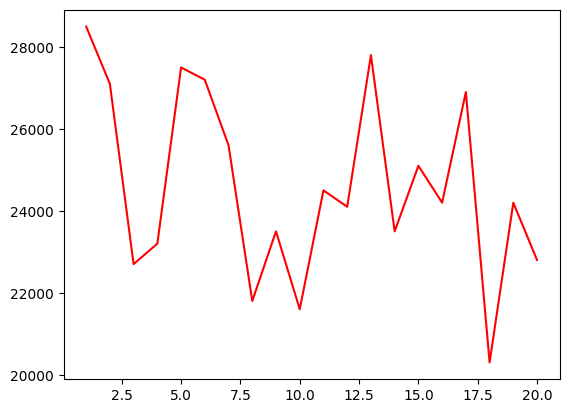

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig18.png')

In [ ]:
print(result_18.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.350
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.286
Time:                        12:38:06   Log-Likelihood:                -181.21
No. Observations:                  20   AIC:                             368.4
Df Residuals:                      17   BIC:                             371.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.674e+04   1680.825     15.911      0.0

In [ ]:
result_18_MA = moving_average(demand)
result_18_ES = exp_smooth(demand)
result_18_seasonES = seasonal_ES(demand)
result_18_HW = holtWinter(demand)

print(result_18_MA)
print(result_18_ES)
print(result_18_seasonES)
print(result_18_HW)

     Demand      Forecast        Error
0   28500.0           NaN          NaN
1   27100.0           NaN          NaN
2   22700.0           NaN          NaN
3   23200.0  26100.000000 -2900.000000
4   27500.0  24333.333333  3166.666667
5   27200.0  24466.666667  2733.333333
6   25600.0  25966.666667  -366.666667
7   21800.0  26766.666667 -4966.666667
8   23500.0  24866.666667 -1366.666667
9   21600.0  23633.333333 -2033.333333
10  24500.0  22300.000000  2200.000000
11  24100.0  23200.000000   900.000000
12  27800.0  23400.000000  4400.000000
13  23500.0  25466.666667 -1966.666667
14  25100.0  25133.333333   -33.333333
15  24200.0  25466.666667 -1266.666667
16  26900.0  24266.666667  2633.333333
17  20300.0  25400.000000 -5100.000000
18  24200.0  23800.000000   400.000000
19  22800.0  23800.000000 -1000.000000
20      NaN  22433.333333          NaN
21      NaN  45933.333333          NaN
22      NaN  56983.333333          NaN
23      NaN  41783.333333          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_18_MA))
print(KPI(result_18_ES))
print(KPI(result_18_seasonES))
print(KPI(result_18_HW))

MAE: 2201.96
MSE: 7135359.48
MAPE: 0.09
None
MAE: 2096.32
MSE: 6711848.57
MAPE: 0.09
None
MAE: 2375.59
MSE: 7952315.65
MAPE: 0.10
None
MAE: 2606.53
MSE: 9626950.06
MAPE: 0.11
None


In [ ]:
#Product 19
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([20400,19300,21400,22400,19200,18100,18500,21300,20000,19700,21400,18300,22500,19600,19700,21400,21500,21400,20700,22800])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_19 = sm.OLS(df[['Demand']], indep)
result_19 = model_19.fit()

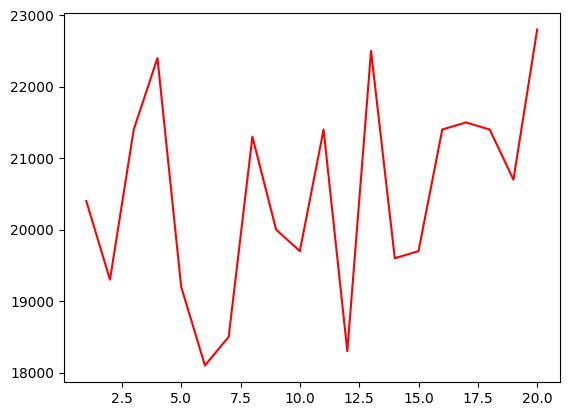

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig19.png')

In [ ]:
print(result_19.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2.345
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.126
Time:                        12:38:06   Log-Likelihood:                -170.49
No. Observations:                  20   AIC:                             347.0
Df Residuals:                      17   BIC:                             350.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.079e+04    983.335     21.142      0.0

In [ ]:
result_19_MA = moving_average(demand)
result_19_ES = exp_smooth(demand)
result_19_seasonES = seasonal_ES(demand)
result_19_HW = holtWinter(demand)

print(result_19_MA)
print(result_19_ES)
print(result_19_seasonES)
print(result_19_HW)

     Demand      Forecast        Error
0   20400.0           NaN          NaN
1   19300.0           NaN          NaN
2   21400.0           NaN          NaN
3   22400.0  20366.666667  2033.333333
4   19200.0  21033.333333 -1833.333333
5   18100.0  21000.000000 -2900.000000
6   18500.0  19900.000000 -1400.000000
7   21300.0  18600.000000  2700.000000
8   20000.0  19300.000000   700.000000
9   19700.0  19933.333333  -233.333333
10  21400.0  20333.333333  1066.666667
11  18300.0  20366.666667 -2066.666667
12  22500.0  19800.000000  2700.000000
13  19600.0  20733.333333 -1133.333333
14  19700.0  20133.333333  -433.333333
15  21400.0  20600.000000   800.000000
16  21500.0  20233.333333  1266.666667
17  21400.0  20866.666667   533.333333
18  20700.0  21433.333333  -733.333333
19  22800.0  21200.000000  1600.000000
20      NaN  21633.333333          NaN
21      NaN  43383.333333          NaN
22      NaN  55308.333333          NaN
23      NaN  40108.333333          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_19_MA))
print(KPI(result_19_ES))
print(KPI(result_19_seasonES))
print(KPI(result_19_HW))

MAE: 1419.61
MSE: 2676339.87
MAPE: 0.07
None
MAE: 1351.12
MSE: 2425099.28
MAPE: 0.07
None
MAE: 1398.53
MSE: 3190338.88
MAPE: 0.07
None
MAE: 1457.91
MSE: 3326595.81
MAPE: 0.07
None


In [ ]:
#Product 20
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([25400,28100,33700,30600,29800,29000,26200,29900,34800,24800,34000,31100,30000,31900,25300,32300,28100,29600,25600,24800])
df = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df['PeriodSqr'] = df['Period'] ** 2
indep = df[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_20 = sm.OLS(df[['Demand']], indep)
result_20 = model_20.fit()

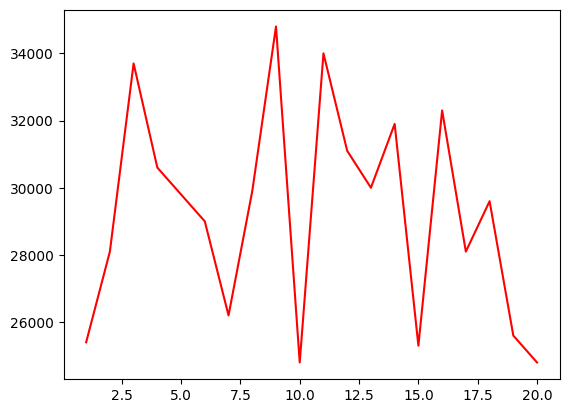

In [ ]:
plt.plot(period, demand, 'r')
plt.savefig('fig20.png')

In [ ]:
print(result_20.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2.175
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.144
Time:                        12:38:07   Log-Likelihood:                -186.85
No. Observations:                  20   AIC:                             379.7
Df Residuals:                      17   BIC:                             382.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.677e+04   2228.188     12.014      0.0

In [ ]:
result_20_MA = moving_average(demand)
result_20_ES = exp_smooth(demand)
result_20_seasonES = seasonal_ES(demand)
result_20_HW = holtWinter(demand)

print(result_20_MA)
print(result_20_ES)
print(result_20_seasonES)
print(result_20_HW)

     Demand      Forecast        Error
0   25400.0           NaN          NaN
1   28100.0           NaN          NaN
2   33700.0           NaN          NaN
3   30600.0  29066.666667  1533.333333
4   29800.0  30800.000000 -1000.000000
5   29000.0  31366.666667 -2366.666667
6   26200.0  29800.000000 -3600.000000
7   29900.0  28333.333333  1566.666667
8   34800.0  28366.666667  6433.333333
9   24800.0  30300.000000 -5500.000000
10  34000.0  29833.333333  4166.666667
11  31100.0  31200.000000  -100.000000
12  30000.0  29966.666667    33.333333
13  31900.0  31700.000000   200.000000
14  25300.0  31000.000000 -5700.000000
15  32300.0  29066.666667  3233.333333
16  28100.0  29833.333333 -1733.333333
17  29600.0  28566.666667  1033.333333
18  25600.0  30000.000000 -4400.000000
19  24800.0  27766.666667 -2966.666667
20      NaN  26666.666667          NaN
21      NaN  51866.666667          NaN
22      NaN  64066.666667          NaN
23      NaN  47533.333333          NaN
     Demand      Forecast

In [ ]:
print(KPI(result_20_MA))
print(KPI(result_20_ES))
print(KPI(result_20_seasonES))
print(KPI(result_20_HW))

MAE: 2680.39
MSE: 11093790.85
MAPE: 0.09
None
MAE: 2945.15
MSE: 13592520.31
MAPE: 0.10
None
MAE: 4024.22
MSE: 25559559.26
MAPE: 0.14
None
MAE: 3864.92
MSE: 25732456.29
MAPE: 0.14
None


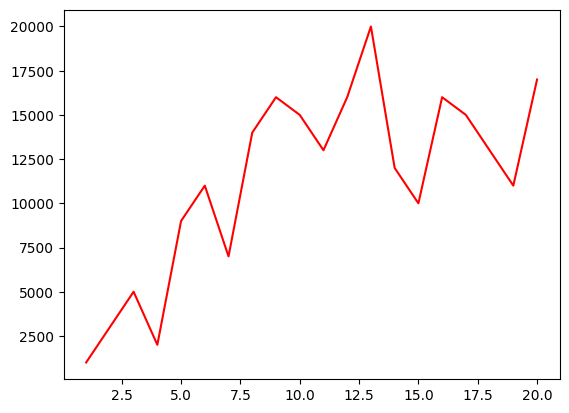

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     15.72
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           4.99e-05
Time:                        12:38:07   Log-Likelihood:                -185.80
No. Observations:                  20   AIC:                             379.6
Df Residuals:                      16   BIC:                             383.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -574.5614   2516.730     -0.228      0.8

In [ ]:
# productID: 21
period = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
demand = np.array([1000,3000,5000,2000,9000,11000,7000,14000,16000,15000,13000,16000,20000,12000,10000,16000,15000,13000,11000,17000])
plt.plot(period, demand, c = 'r')
plt.show()
qtr = np.array([1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4])
df_21 = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df_21['PeriodSqr'] = df_21['Period'] ** 2
df_21['Quarter'] = qtr
indep = df_21[['Period', 'PeriodSqr', 'Quarter']]
indep = sm.add_constant(indep)
model_21 = sm.OLS(df_21[['Demand']], indep)
result_21 = model_21.fit()
print(result_21.summary())

period_fore = np.array([21,22,23,24])
qtr_fore = np.array([1,2,3,4])
periodSqr_fore = period_fore ** 2
indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'PeriodSqr': periodSqr_fore, 'Quarter': qtr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_21.predict(indep_fore)
print(indep_fore)

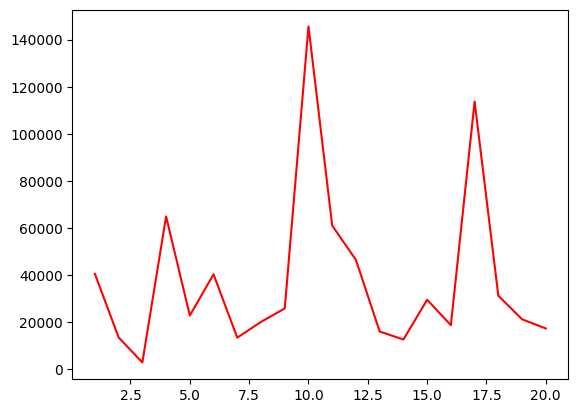

MAE: 32093.14
MSE: 2190529918.30
MAPE: 1.02
      Demand      Forecast          Error
0    40500.0           NaN            NaN
1    13500.0           NaN            NaN
2     2850.0           NaN            NaN
3    64900.0  18950.000000   45950.000000
4    22800.0  27083.333333   -4283.333333
5    40300.0  30183.333333   10116.666667
6    13400.0  42666.666667  -29266.666667
7    20100.0  25500.000000   -5400.000000
8    25800.0  24600.000000    1200.000000
9   145600.0  19766.666667  125833.333333
10   61000.0  63833.333333   -2833.333333
11   46400.0  77466.666667  -31066.666667
12   16000.0  84333.333333  -68333.333333
13   12600.0  41133.333333  -28533.333333
14   29500.0  25000.000000    4500.000000
15   18700.0  19366.666667    -666.666667
16  113700.0  20266.666667   93433.333333
17   31200.0  53966.666667  -22766.666667
18   21200.0  54533.333333  -33333.333333
19   17300.0  55366.666667  -38066.666667
20       NaN  23233.333333            NaN
21       NaN  42483.333333      

In [ ]:
# productID: 22
demand = np.array([40500,13500,2850,64900,22800,40300,13400,20100,25800,145600,61000,46400,16000,12600,29500,18700,113700,31200,21200,17300])
plt.plot(period, demand, c = 'r')
plt.show()
df = moving_average(demand)
KPI(df)
print(df)
df = exp_smooth(demand)
KPI(df)
print(df)
df = seasonal_ES(demand)
KPI(df)
print(df)
df = holtWinter(demand)
KPI(df)

df_22 = pd.DataFrame.from_dict({'Period':period, 'Demand':demand})
df_22['PeriodSqr'] = df_22['Period'] ** 2
df_22['Quarter'] = qtr
indep = df_22[['Period', 'PeriodSqr', 'Quarter']]
indep = sm.add_constant(indep)
model_22 = sm.OLS(df_22[['Demand']], indep)
result_22 = model_22.fit()
print(result_22.summary())

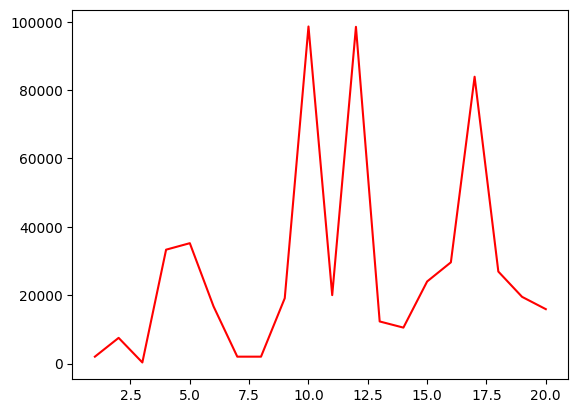

0.34702882362526233
[ 0.00000000e+00  2.23255084e+03 -1.50654899e+02 -1.02657199e+04
  7.34556286e+05  0.00000000e+00  7.27553559e+03  1.36168407e+02]
-1300563.3069548896
[  4312.12900277   7433.02519301 -11666.58047037  17824.55827242
  29665.25341807  30082.42371516  10894.10035405  37299.5479958
  49080.89957366  55726.51592763  31983.38889378  52335.54616113
  31854.6756321   36942.46171663  13110.61698504  33403.43068461
  34576.68821534  38459.23510838  13422.1511853   41059.93243549]
MAE: 18837.22
MSE: 569283713.23
MAPE: 3.76
[71879.21326194 48112.5961914  25219.83755809 49771.92770724]
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter 

In [ ]:
# productID: 23
# Mutiple Rregression
# Lasso (L1)
demand = np.array([2000,7500,300,33300,35200,16700,2000,2000,19100,98600,20000,98500,12300,10500,24000,29600,83900,26900,19500,15900])
plt.plot(period, demand, c = 'r')
plt.show()
df_23 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_23['PeriodSqr'] = df_23['Period'] ** 2
df_23 = sm.add_constant(df_23)

GDP = np.array([0.225,0.256,0.245,0.296,0.231,0.263,0.252,0.305,0.237,0.27,0.259,0.313,0.224,0.255,0.244,0.295,0.228,0.259,0.248,0.3])
CPI = np.array([1.028,1.018,1.016,1.017,1.042,1.03,1.029,1.027,1.055,1.049,1.045,1.038,1.052,1.047,1.044,1.04,1.06,1.055,1.052,1.055])

cost = 150
Cost = cost * CPI

price = 185
Price = price * CPI

indVar = np.array([df_23['const'], df_23['Period'], df_23['PeriodSqr'], qtr, GDP, CPI, Cost, Price])

lasso_23 = Lasso(alpha = 10, max_iter = 10000)
lasso_23.fit(indVar.T, df_23['Order_Demand'])
print(lasso_23.score(indVar.T, df_23['Order_Demand']))
coeff = lasso_23.coef_
intercept = lasso_23.intercept_
print(coeff)
print(intercept)

fore_23 = lasso_23.predict(indVar.T)
print(fore_23)
kpi23 = pd.DataFrame.from_dict({'Demand': df_23['Order_Demand'], 'Forecast': fore_23, 'Error': df_23['Order_Demand'] - fore_23})
KPI(kpi23)

const = np.array([1,1,1,1])
GDP_fore = np.array([0.237,0.27,0.259,0.313])
CPI_fore = np.array([1.1,1.07,1.07,1.07])
cost_fore = np.zeros(4)
price_fore = np.zeros(4)
for i in range(4):
  cost_fore[i] = cost * CPI_fore[i]
  price_fore[i] = price * CPI_fore[i]

indVar_fore = np.array([const, period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])

fore_23 = lasso_23.predict(indVar_fore.T)
print(fore_23)


# L0 regression
indVar = np.array([df_23['Period'], df_23['PeriodSqr'], qtr, GDP, CPI, Cost, Price])
intcep, beta = L0_regression(indVar.T, df_23['Order_Demand'], 2, standardize = False, seed = None)
print(intcep)
print(beta)

fore_L0 = np.zeros(4)
indVar_fore = np.array([period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
for i in range(4):
  for j in range(len(beta)):
    if(beta[j] >= 0.0001 or beta[j] <= -0.0001): # coefficients whose absolute value are less than 0.0001 will be considered filtered out
      fore_L0[i] += (beta[j] * indVar_fore[j][i] + intcep)

print(fore_L0)

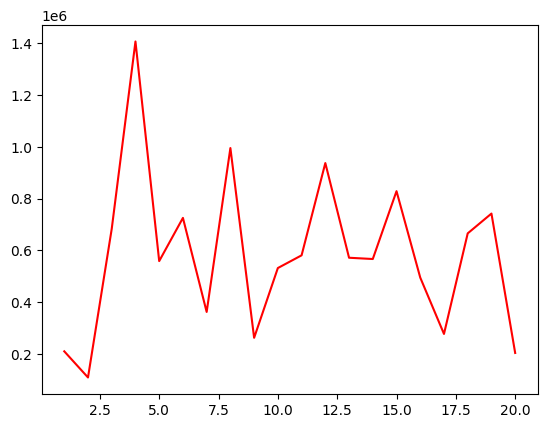

MAE: 291689.22
MSE: 147880543741.83
MAPE: 0.58
       Demand      Forecast         Error
0    210500.0           NaN           NaN
1    109650.0           NaN           NaN
2    682950.0           NaN           NaN
3   1405700.0  3.343667e+05  1.071333e+06
4    558600.0  7.327667e+05 -1.741667e+05
5    725200.0  8.824167e+05 -1.572167e+05
6    362400.0  8.965000e+05 -5.341000e+05
7    994600.0  5.487333e+05  4.458667e+05
8    262700.0  6.940667e+05 -4.313667e+05
9    531800.0  5.399000e+05 -8.100000e+03
10   580800.0  5.963667e+05 -1.556667e+04
11   936700.0  4.584333e+05  4.782667e+05
12   571500.0  6.831000e+05 -1.116000e+05
13   566600.0  6.963333e+05 -1.297333e+05
14   828300.0  6.916000e+05  1.367000e+05
15   495000.0  6.554667e+05 -1.604667e+05
16   277600.0  6.299667e+05 -3.523667e+05
17   665500.0  5.336333e+05  1.318667e+05
18   741900.0  4.793667e+05  2.625333e+05
19   204200.0  5.616667e+05 -3.574667e+05
20        NaN  5.372000e+05           NaN
21        NaN  1.010250e+06  

In [ ]:
# productID: 24
demand = np.array([210500,109650,682950,1405700,558600,725200,362400,994600,262700,531800,580800,936700,571500,566600,828300,495000,277600,665500,741900,204200])
plt.plot(period, demand, c = 'r')
plt.show()
df = moving_average(demand)
KPI(df)
print(df)
df = exp_smooth(demand)
KPI(df)
print(df)
df = seasonal_ES(demand)
KPI(df)
print(df)
df = holtWinter(demand)
KPI(df)

df_24 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_24['PeriodSqr'] = df_24['Period'] ** 2
df_24['Quarter'] = qtr
indep = df_24[['Period', 'PeriodSqr', 'Quarter']]
indep = sm.add_constant(indep)
model_24 = sm.OLS(df_24[['Order_Demand']], indep)
result_24 = model_24.fit()
print(result_24.summary())

indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'PeriodSqr': periodSqr_fore, 'Quarter': qtr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_24.predict(indep_fore)
print(indep_fore)

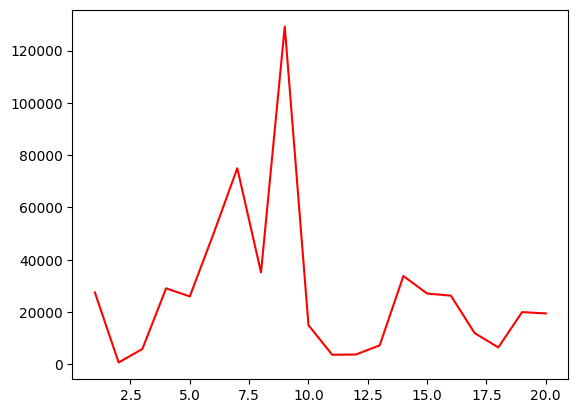

MAE: 26331.37
MSE: 1174680228.76
MAPE: 2.39
      Demand      Forecast         Error
0    27500.0           NaN           NaN
1      750.0           NaN           NaN
2     5900.0           NaN           NaN
3    29100.0  11383.333333  17716.666667
4    26000.0  11916.666667  14083.333333
5    50000.0  20333.333333  29666.666667
6    75000.0  35033.333333  39966.666667
7    35200.0  50333.333333 -15133.333333
8   129200.0  53400.000000  75800.000000
9    15000.0  79800.000000 -64800.000000
10    3700.0  59800.000000 -56100.000000
11    3800.0  49300.000000 -45500.000000
12    7300.0   7500.000000   -200.000000
13   33800.0   4933.333333  28866.666667
14   27100.0  14966.666667  12133.333333
15   26300.0  22733.333333   3566.666667
16   12000.0  29066.666667 -17066.666667
17    6500.0  21800.000000 -15300.000000
18   20000.0  14933.333333   5066.666667
19   19500.0  12833.333333   6666.666667
20       NaN  15333.333333           NaN
21       NaN  35083.333333           NaN
22       NaN 

In [ ]:
# productID: 25
demand = np.array([27500,750,5900,29100,26000,50000,75000,35200,129200,15000,3700,3800,7300,33800,27100,26300,12000,6500,20000,19500])
plt.plot(period, demand, c = 'r')
plt.show()
df = moving_average(demand)
KPI(df)
print(df)
df = exp_smooth(demand)
KPI(df)
print(df)
df = seasonal_ES(demand)
KPI(df)
print(df)
df = holtWinter(demand)
KPI(df)

df_25 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_25['PeriodSqr'] = df_25['Period'] ** 2
indep = df_25[['Period', 'PeriodSqr']]
indep = sm.add_constant(indep)
model_25 = sm.OLS(df_25[['Order_Demand']], indep)
result_25 = model_25.fit()
print(result_25.summary())

indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'PeriodSqr': periodSqr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_25.predict(indep_fore)
print(indep_fore)

0.21786210461529631
[ 0.00000000e+00 -5.08723934e+02 -1.56854379e+01  4.33896844e+03
 -1.43556242e+05  0.00000000e+00  5.11609491e+02  2.31826086e-01]
-134966.2220014242
MAE: 5274.59
MSE: 36998642.07
MAPE: 0.77
[14830.01905549  7873.5087621  12577.02722166  7918.01907807]
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
20190.16620498615
[  0.        -20.4889631   0.          0.          0.          0.
   0.       ]
[11154.53347747 10273.50806413  9351.50472458  8388.52345884]


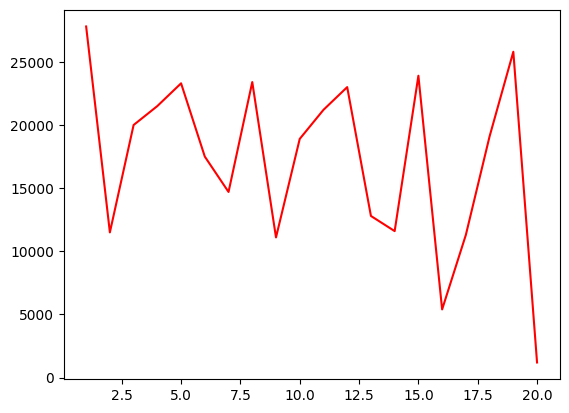

In [ ]:
# productID: 26
# Mutiple Rregression
# warehouse: A
# Lasso (L1)
demand_26A = np.array([27800,11500,20000,21500,23300,17500,14700,23400,11100,18900,21200,23000,12800,11600,23900,5400,11300,19100,25800,1200])
plt.plot(period, demand_26A, c = 'r', label = 'warehouse: A')
df_26A = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_26A})
df_26A['PeriodSqr'] = df_26A['Period'] ** 2
df_26A = sm.add_constant(df_26A)

cost = 350
Cost = cost * CPI

price = 435
Price = price * CPI

indVar = np.array([df_26A['const'], df_26A['Period'], df_26A['PeriodSqr'], qtr, GDP, CPI, Cost, Price])

lasso_26A = Lasso(alpha = 0.1, max_iter = 10000)
lasso_26A.fit(indVar.T, df_26A['Order_Demand'])
print(lasso_26A.score(indVar.T, df_26A['Order_Demand']))

coeff = lasso_26A.coef_
intercept = lasso_26A.intercept_
print(coeff)
print(intercept)

fore_26A = lasso_26A.predict(indVar.T)
kpi26A = pd.DataFrame.from_dict({'Demand': df_26A['Order_Demand'], 'Forecast': fore_26A, 'Error': df_26A['Order_Demand'] - fore_26A})
KPI(kpi26A)

for i in range(4):
  cost_fore[i] = cost * CPI_fore[i]
  price_fore[i] = price * CPI_fore[i]

indVar_fore = np.array([const, period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
fore_26A = lasso_26A.predict(indVar_fore.T)
print(fore_26A)


# L0 regression
indVar = np.array([df_26A['Period'], df_26A['PeriodSqr'], qtr, GDP, CPI, Cost, Price])
intcep, beta = L0_regression(indVar.T, df_26A['Order_Demand'], 2, standardize = False, seed = None)
print(intcep)
print(beta)

fore_L0 = np.zeros(4)
indVar_fore = np.array([period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
for i in range(4):
  for j in range(len(beta)):
    if(beta[j] >= 0.0001 or beta[j] <= -0.0001):
      fore_L0[i] += (beta[j] * indVar_fore[j][i] + intcep)

print(fore_L0)

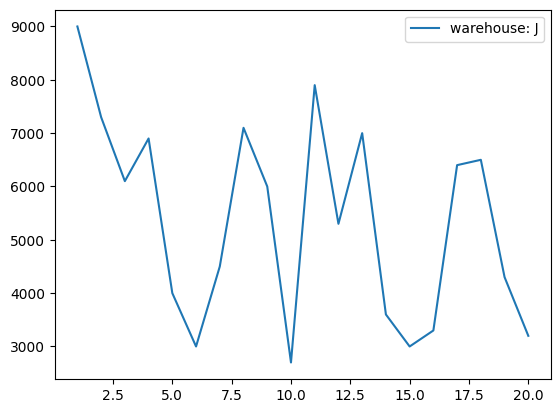

0.21660440653546187
[   0.         -411.40073215   12.50390504 -141.98073369   -0.
    0.           29.88127667    5.02173123]
-4912.634620302648
MAE: 1428.48
MSE: 2696036.35
MAPE: 0.32
[5727.3813016  5332.38075484 5341.67501569 5375.97708661]
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
6721.578947368423
[-130.15037594    0.            0.            0.            0.
    0.            0.        ]
[3988.42105263 3858.27067669 3728.12030075 3597.96992481]


In [ ]:
# productID: 26
# warehouse: J
# Lasso (L1)
demand_26J = np.array([9000,7300,6100,6900,4000,3000,4500,7100,6000,2700,7900,5300, 7000,3600,3000,3300,6400,6500,4300,3200])
plt.plot(period, demand_26J, label = 'warehouse: J')
plt.legend()
plt.show()
df_26J = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_26J})
df_26J['PeriodSqr'] = df_26J['Period'] ** 2
df_26J = sm.add_constant(df_26J)

cost = 350
Cost = cost * CPI

price = 435
Price = price * CPI

indVar = np.array([df_26A['const'], df_26J['Period'], df_26J['PeriodSqr'], qtr, GDP, CPI, Cost, Price])

lasso_26J = Lasso(alpha = 3, max_iter = 10000)
lasso_26J.fit(indVar.T, df_26J['Order_Demand'])
print(lasso_26J.score(indVar.T, df_26J['Order_Demand']))

coeff = lasso_26J.coef_
intercept = lasso_26J.intercept_
print(coeff)
print(intercept)

fore_26J = lasso_26J.predict(indVar.T)
kpi26J = pd.DataFrame.from_dict({'Demand': df_26J['Order_Demand'], 'Forecast': fore_26J, 'Error': df_26J['Order_Demand'] - fore_26J})
KPI(kpi26J)

for i in range(4):
  cost_fore[i] = cost * CPI_fore[i]
  price_fore[i] = price * CPI_fore[i]

indVar_fore = np.array([const, period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
fore_26J = lasso_26J.predict(indVar_fore.T)
print(fore_26J)


# L0 regression
indVar = np.array([df_26J['Period'], df_26J['PeriodSqr'], qtr, GDP, CPI, Cost, Price])
intcep, beta = L0_regression(indVar.T, df_26J['Order_Demand'], 2, standardize = False, seed = None)
print(intcep)
print(beta)

fore_L0 = np.zeros(4)
indVar_fore = np.array([period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
for i in range(4):
  for j in range(len(beta)):
    if(beta[j] >= 0.0001 or beta[j] <= -0.0001):
      fore_L0[i] += (beta[j] * indVar_fore[j][i] + intcep)

print(fore_L0)

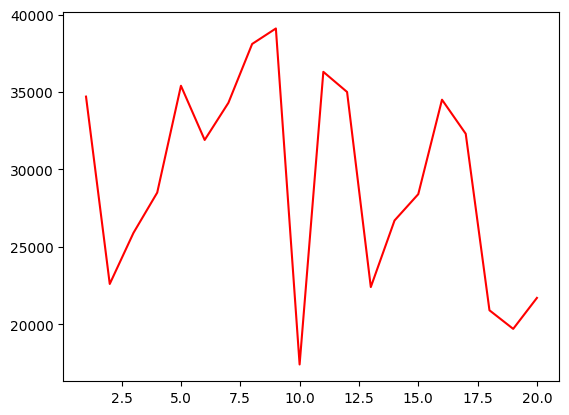

     Demand      Forecast         Level        Trend       Season  \
0   34700.0           NaN  27925.000000     0.000000  6775.000000   
1   22600.0           NaN  27925.000000     0.000000 -5325.000000   
2   25900.0           NaN  27925.000000     0.000000 -2025.000000   
3   28500.0           NaN  27925.000000     0.000000   575.000000   
4   35400.0  34700.000000  28135.000000    84.000000  6922.000000   
5   31900.0  22894.000000  30920.800000  1164.720000 -3433.740000   
6   34300.0  30060.520000  33357.364000  1673.457600 -1134.709200   
7   38100.0  35605.821600  35779.075120  1972.759008  1098.777464   
8   39100.0  44673.834128  36079.683890  1303.898913  5751.494833   
9   17400.0  33949.842802  32418.629962  -682.082224 -6909.206988   
10  36300.0  30601.838538  33445.996177     1.697152    61.904707   
11  35000.0  34546.470792  33583.752091    56.120657  1194.018598   
12  22400.0  39391.367581  28542.462473 -1982.843453  2183.307641   
13  26700.0  19650.412032  28674.4

In [ ]:
# productID = 27
demand = np.array([34700,22600,25900,28500,35400,31900,34300,38100,39100,17400,36300,35000,22400,26700,28400,34500,32300,20900,19700,21700])
plt.plot(period, demand, c = 'r')
plt.show()
result_27 = holtWinter(demand)
print(result_27)
KPI(result_27)

df_27 = seasonal_ES(demand)
print(df_27)
KPI(df_27)

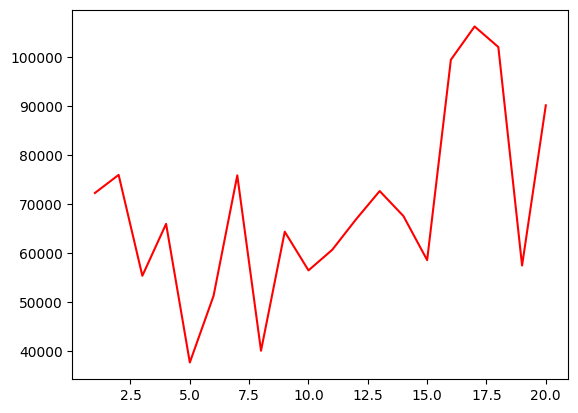

0.4557312445268269
[ 0.00000000e+00  2.44338063e+02  1.75736415e+02 -1.41991882e+04
  2.80883128e+05 -0.00000000e+00 -4.21634422e+03 -1.61742392e+01]
1105651.5471279449
MAE: 10966.17
MSE: 185126091.35
MAPE: 0.18
[ 74752.8603461  109421.08267887 100284.65680177 109757.1070789 ]
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
56789.63988919668
[ 0.         83.59135966  0.          0.          0.          0.
  0.        ]
[ 93653.42949801  97247.85796327 101009.46914784 104938.26305172]


In [ ]:
# productID: 28
# Mutiple Rregression
# Lasso (L1)
demand = np.array([72200,75900,55300,65900,37600,51200,75800,40000,64300,56400,60600,66800,72600,67500,58500,99400,106200,102000,57400,90100])
plt.plot(period, demand, c = 'r')
plt.show()
df_28 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_28['PeriodSqr'] = df_28['Period'] ** 2
df_28 = sm.add_constant(df_28)

cost = 250
Cost = cost * CPI

price = 360
Price = price * CPI

indVar = np.array([df_28['const'], df_28['Period'], df_28['PeriodSqr'], qtr, GDP, CPI, Cost, Price])

lasso_28 = Lasso(alpha = 3, max_iter = 10000)
lasso_28.fit(indVar.T, df_28['Order_Demand'])
print(lasso_28.score(indVar.T, df_28['Order_Demand']))

coeff = lasso_28.coef_
intercept = lasso_28.intercept_
print(coeff)
print(intercept)

fore_28 = lasso_28.predict(indVar.T)
kpi28 = pd.DataFrame.from_dict({'Demand': df_28['Order_Demand'], 'Forecast': fore_28, 'Error': df_28['Order_Demand'] - fore_28})
KPI(kpi28)

for i in range(4):
  cost_fore[i] = cost * CPI_fore[i]
  price_fore[i] = price * CPI_fore[i]

indVar_fore = np.array([const, period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
fore_28 = lasso_28.predict(indVar_fore.T)
print(fore_28)


# L0 regression
indVar = np.array([df_28['Period'], df_28['PeriodSqr'], qtr, GDP, CPI, Cost, Price])
intcep, beta = L0_regression(indVar.T, df_28['Order_Demand'], 2, standardize = False, seed = 5566)
print(intcep)
print(beta)

fore_L0_28 = np.zeros(4)
indVar_fore = np.array([period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
for i in range(4):
  for j in range(len(beta)):
    if(beta[j] >= 0.0001 or beta[j] <= -0.0001):
      fore_L0_28[i] += (beta[j] * indVar_fore[j][i] + intcep)

print(fore_L0_28)

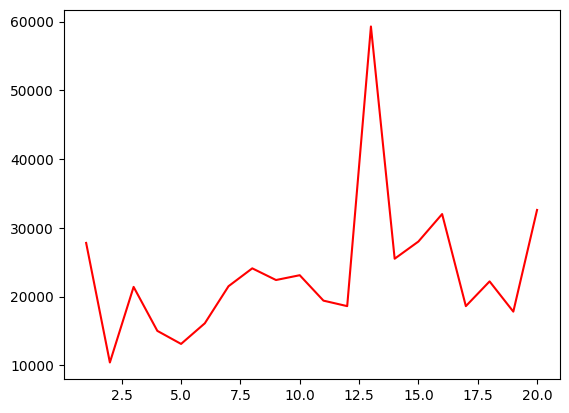

MAE: 7188.24
MSE: 124619477.12
MAPE: 0.26
     Demand      Forecast         Error
0   27800.0           NaN           NaN
1   10400.0           NaN           NaN
2   21400.0           NaN           NaN
3   15000.0  19866.666667  -4866.666667
4   13100.0  15600.000000  -2500.000000
5   16100.0  16500.000000   -400.000000
6   21500.0  14733.333333   6766.666667
7   24100.0  16900.000000   7200.000000
8   22400.0  20566.666667   1833.333333
9   23100.0  22666.666667    433.333333
10  19400.0  23200.000000  -3800.000000
11  18600.0  21633.333333  -3033.333333
12  59300.0  20366.666667  38933.333333
13  25500.0  32433.333333  -6933.333333
14  28000.0  34466.666667  -6466.666667
15  32000.0  37600.000000  -5600.000000
16  18600.0  28500.000000  -9900.000000
17  22200.0  26200.000000  -4000.000000
18  17800.0  24266.666667  -6466.666667
19  32600.0  19533.333333  13066.666667
20      NaN  24200.000000           NaN
21      NaN  49400.000000           NaN
22      NaN  69400.000000           Na

In [ ]:
# productID: 29
demand = np.array([27800,10400,21400,15000,13100,16100,21500,24100,22400,23100,19400,18600,59300,25500,28000,32000,18600,22200,17800,32600])
plt.plot(period, demand, c = 'r')
plt.show()
df = moving_average(demand)
KPI(df)
print(df)
df = exp_smooth(demand)
KPI(df)
print(df)
df = seasonal_ES(demand)
KPI(df)
print(df)
df = holtWinter(demand)
KPI(df)

df_29 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_29['Quarter'] = qtr
indep = df_29[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_29 = sm.OLS(df_29[['Order_Demand']], indep)
result_29 = model_29.fit()
print(result_29.summary())

indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'PeriodSqr': periodSqr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_29.predict(indep_fore)
print(indep_fore)

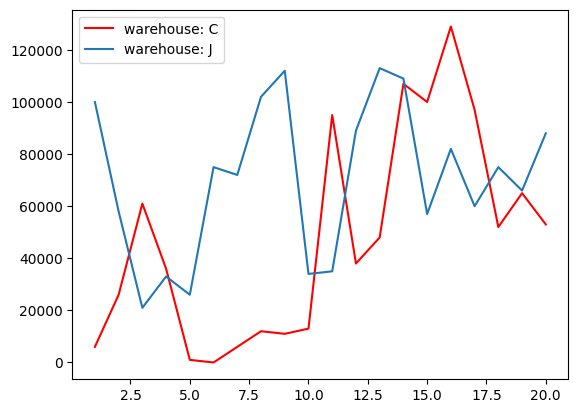

In [ ]:
# productID: 30
demand_30C = np.array([6000,26000,61000,36000,1000,0,6000,12000,11000,13000,95000,38000,48000,107000,100000,129000,97000,52000,65000,53000])
demand_30J = np.array([100000,58000,21000,33000,26000,75000,72000,102000,112000,34000,35000,89000,113000,109000,57000,82000,60000,75000,66000,88000])
plt.plot(period, demand_30C, c = 'r', label = 'warehouse: C')
plt.plot(period, demand_30J, label = 'warehouse: J')
plt.legend()
plt.show()

In [ ]:
# productID: 30
# warehouse: C
df = moving_average(demand_30C)
KPI(df)
print(df)
df = exp_smooth(demand_30C)
KPI(df)
print(df)
df = seasonal_ES(demand_30C)
KPI(df)
df = holtWinter(demand_30C)
KPI(df)

df_30C = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_30C})
df_30C['Quarter'] = qtr
indep = df_30C[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_30 = sm.OLS(df_30C[['Order_Demand']], indep)
result_30C = model_30.fit()
print(result_30C.summary())

indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'Quarter': qtr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_30C.predict(indep_fore)
print(indep_fore)

MAE: 25372.55
MSE: 1157503267.97
MAPE: inf
      Demand       Forecast         Error
0     6000.0            NaN           NaN
1    26000.0            NaN           NaN
2    61000.0            NaN           NaN
3    36000.0   31000.000000   5000.000000
4     1000.0   41000.000000 -40000.000000
5        0.0   32666.666667 -32666.666667
6     6000.0   12333.333333  -6333.333333
7    12000.0    2333.333333   9666.666667
8    11000.0    6000.000000   5000.000000
9    13000.0    9666.666667   3333.333333
10   95000.0   12000.000000  83000.000000
11   38000.0   39666.666667  -1666.666667
12   48000.0   48666.666667   -666.666667
13  107000.0   60333.333333  46666.666667
14  100000.0   64333.333333  35666.666667
15  129000.0   85000.000000  44000.000000
16   97000.0  112000.000000 -15000.000000
17   52000.0  108666.666667 -56666.666667
18   65000.0   92666.666667 -27666.666667
19   53000.0   71333.333333 -18333.333333
20       NaN   56666.666667           NaN
21       NaN  115666.666667      

In [ ]:
# productID: 30
# warehouse: J
df = moving_average(demand_30J)
KPI(df)
print(df)
df = exp_smooth(demand_30J)
KPI(df)
print(df)
df = seasonal_ES(demand_30J)
KPI(df)
print(df)
df = holtWinter(demand_30J)
KPI(df)

df_30J = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_30J})
df_30J['Quarter'] = qtr
indep = df_30J[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_30 = sm.OLS(df_30J[['Order_Demand']], indep)
result_30J = model_30.fit()
print(result_30J.summary())

MAE: 31254.90
MSE: 1264339869.28
MAPE: 0.53
      Demand       Forecast         Error
0   100000.0            NaN           NaN
1    58000.0            NaN           NaN
2    21000.0            NaN           NaN
3    33000.0   59666.666667 -26666.666667
4    26000.0   37333.333333 -11333.333333
5    75000.0   26666.666667  48333.333333
6    72000.0   44666.666667  27333.333333
7   102000.0   57666.666667  44333.333333
8   112000.0   83000.000000  29000.000000
9    34000.0   95333.333333 -61333.333333
10   35000.0   82666.666667 -47666.666667
11   89000.0   60333.333333  28666.666667
12  113000.0   52666.666667  60333.333333
13  109000.0   79000.000000  30000.000000
14   57000.0  103666.666667 -46666.666667
15   82000.0   93000.000000 -11000.000000
16   60000.0   82666.666667 -22666.666667
17   75000.0   66333.333333   8666.666667
18   66000.0   72333.333333  -6333.333333
19   88000.0   67000.000000  21000.000000
20       NaN   76333.333333           NaN
21       NaN  153333.333333     

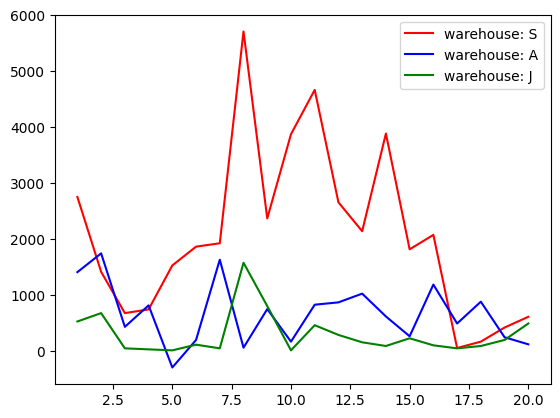

In [ ]:
# productID: 31
demand_31S = np.array([2748,1410,672,738,1524,1860,1920,5706,2364,3870,4662,2652,2136,3882,1812,2070,48,162,414,606])
demand_31A = np.array([1404,1740,426,810,-300,192,1626,54,744,162,822,864,1020,612,258,1182,486,876,240,114])
demand_31J = np.array([522,672,42,24,6,108,42,1572,798,6,456,282,150,84,222,96,42,84,192,486])
plt.plot(period, demand_31S, c = 'r', label = 'warehouse: S')
plt.plot(period, demand_31A, c = 'b', label = 'warehouse: A')
plt.plot(period, demand_31J, c = 'g', label = 'warehouse: J')
plt.legend()
plt.show()

In [ ]:
# productID: 31
# warehouse: S
df = moving_average(demand_31S)
KPI(df)
print(df)
df = exp_smooth(demand_31S)
KPI(df)
print(df)
df = seasonal_ES(demand_31S)
KPI(df)
df = holtWinter(demand_31S)
KPI(df)

df_31S = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_31S})
df_31S['Quarter'] = qtr
indep = df_31S[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_31S = sm.OLS(df_31S[['Order_Demand']], indep)
result_31S = model_31S.fit()
print(result_31S.summary())

MAE: 1070.35
MSE: 1918285.18
MAPE: 3.96
    Demand  Forecast   Error
0   2748.0       NaN     NaN
1   1410.0       NaN     NaN
2    672.0       NaN     NaN
3    738.0    1610.0  -872.0
4   1524.0     940.0   584.0
5   1860.0     978.0   882.0
6   1920.0    1374.0   546.0
7   5706.0    1768.0  3938.0
8   2364.0    3162.0  -798.0
9   3870.0    3330.0   540.0
10  4662.0    3980.0   682.0
11  2652.0    3632.0  -980.0
12  2136.0    3728.0 -1592.0
13  3882.0    3150.0   732.0
14  1812.0    2890.0 -1078.0
15  2070.0    2610.0  -540.0
16    48.0    2588.0 -2540.0
17   162.0    1310.0 -1148.0
18   414.0     760.0  -346.0
19   606.0     208.0   398.0
20     NaN     394.0     NaN
21     NaN     904.0     NaN
22     NaN    1255.0     NaN
23     NaN     851.0     NaN
MAE: 1159.13
MSE: 2067168.57
MAPE: 3.61
    Demand     Forecast        Error
0   2748.0          NaN          NaN
1   1410.0  2748.000000 -1338.000000
2    672.0  2212.800000 -1540.800000
3    738.0  1596.480000  -858.480000
4   1524.0

In [ ]:
# productID: 31
# warehouse: A
df = moving_average(demand_31A)
KPI(df)
print(df)
df = exp_smooth(demand_31A)
KPI(df)
df = seasonal_ES(demand_31A)
KPI(df)
df = holtWinter(demand_31A)
KPI(df)
print(df)

df_31A = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_31A})
df_31A['Quarter'] = qtr
indep = df_31A[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_31A = sm.OLS(df_31A[['Order_Demand']], indep)
result_31A = model_31A.fit()
print(result_31A.summary())

MAE: 498.35
MSE: 368130.35
MAPE: 1.27
    Demand  Forecast   Error
0   1404.0       NaN     NaN
1   1740.0       NaN     NaN
2    426.0       NaN     NaN
3    810.0    1190.0  -380.0
4   -300.0     992.0 -1292.0
5    192.0     312.0  -120.0
6   1626.0     234.0  1392.0
7     54.0     506.0  -452.0
8    744.0     624.0   120.0
9    162.0     808.0  -646.0
10   822.0     320.0   502.0
11   864.0     576.0   288.0
12  1020.0     616.0   404.0
13   612.0     902.0  -290.0
14   258.0     832.0  -574.0
15  1182.0     630.0   552.0
16   486.0     684.0  -198.0
17   876.0     642.0   234.0
18   240.0     848.0  -608.0
19   114.0     534.0  -420.0
20     NaN     410.0     NaN
21     NaN     587.0     NaN
22     NaN     612.5     NaN
23     NaN     536.5     NaN
MAE: 516.20
MSE: 382444.52
MAPE: 1.58
MAE: 712.18
MSE: 806445.75
MAPE: 1.88
MAE: 719.70
MSE: 856184.25
MAPE: 1.41
    Demand     Forecast        Level       Trend      Season        Error
0   1404.0          NaN  1095.000000    0.000000 

In [ ]:
# productID: 31
# warehouse: J
df = moving_average(demand_31J)
KPI(df)
print(df)
df = exp_smooth(demand_31J)
KPI(df)
print(df)
df = seasonal_ES(demand_31J)
KPI(df)
df = holtWinter(demand_31J)
KPI(df)

df_31J = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_31J})
df_31J['Quarter'] = qtr
indep = df_31J[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_31J = sm.OLS(df_31J[['Order_Demand']], indep)
result_31J = model_31J.fit()
print(result_31J.summary())

MAE: 280.82
MSE: 210164.94
MAPE: 11.79
    Demand  Forecast   Error
0    522.0       NaN     NaN
1    672.0       NaN     NaN
2     42.0       NaN     NaN
3     24.0     412.0  -388.0
4      6.0     246.0  -240.0
5    108.0      24.0    84.0
6     42.0      46.0    -4.0
7   1572.0      52.0  1520.0
8    798.0     574.0   224.0
9      6.0     804.0  -798.0
10   456.0     792.0  -336.0
11   282.0     420.0  -138.0
12   150.0     248.0   -98.0
13    84.0     296.0  -212.0
14   222.0     172.0    50.0
15    96.0     152.0   -56.0
16    42.0     134.0   -92.0
17    84.0     120.0   -36.0
18   192.0      74.0   118.0
19   486.0     106.0   380.0
20     NaN     254.0     NaN
21     NaN     593.0     NaN
22     NaN     909.5     NaN
23     NaN     585.5     NaN
MAE: 264.65
MSE: 183916.35
MAPE: 10.47
    Demand    Forecast        Error
0    522.0         NaN          NaN
1    672.0  522.000000   150.000000
2     42.0  582.000000  -540.000000
3     24.0  366.000000  -342.000000
4      6.0  229.2

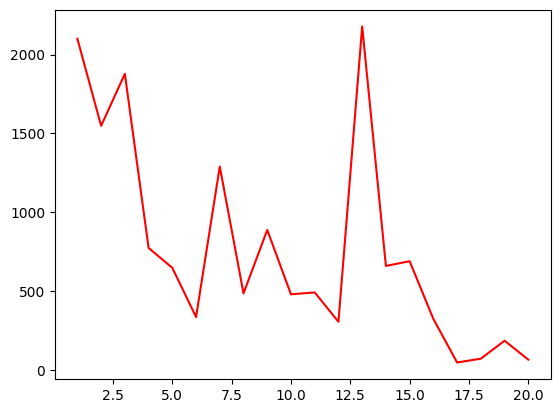

0.5976748447599425
[ 0.00000000e+00 -1.45091077e+01 -7.99490118e-04 -8.81306336e+01
 -9.56598625e+03 -0.00000000e+00 -3.09287977e+01 -2.13167983e-01]
29579.17407960867
MAE: 285.57
MSE: 172832.43
MAPE: 1.38
[-523.58649813 -193.50778092 -190.95765056 -810.19822522]
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
S

In [ ]:
# productID: 32
# Mutiple Rregression
# Lasso (L1)
demand = np.array([2100,1548,1878,774,648,336,1290,486,888,480,492,306,2178,660,690,324,48,72,186,66])
plt.plot(period, demand, c = 'r')
plt.show()

df_32 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_32['PeriodSqr'] = df_32['Period'] ** 2
df_32 = sm.add_constant(df_32)

cost = 800
Cost = cost * CPI

price = 960
Price = price * CPI

indVar = np.array([df_32['const'], df_32['Period'], df_32['PeriodSqr'], qtr, GDP, CPI, Cost, Price])

lasso_32 = Lasso(alpha = 1, max_iter = 10000)
lasso_32.fit(indVar.T, df_32['Order_Demand'])
print(lasso_32.score(indVar.T, df_32['Order_Demand']))

coeff = lasso_32.coef_
intercept = lasso_32.intercept_
print(coeff)
print(intercept)

fore_32 = lasso_32.predict(indVar.T)
kpi32 = pd.DataFrame.from_dict({'Demand': df_32['Order_Demand'], 'Forecast': fore_32, 'Error': df_32['Order_Demand'] - fore_32})
KPI(kpi32)

for i in range(4):
  cost_fore[i] = cost * CPI_fore[i]
  price_fore[i] = price * CPI_fore[i]

indVar_fore = np.array([const, period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
fore_32 = lasso_32.predict(indVar_fore.T)
print(fore_32)


# L0 regression
indVar = np.array([df_32['Period'], df_32['PeriodSqr'], qtr, GDP, CPI, Cost, Price])
intcep, beta = L0_regression(indVar.T, df_32['Order_Demand'], 5, standardize = False, seed = None)
print(intcep)
print(beta)

fore_L0_32 = np.zeros(4)
indVar_fore = np.array([period_fore, periodSqr_fore, qtr_fore, GDP_fore, CPI_fore, cost_fore, price_fore])
for i in range(4):
  for j in range(len(beta)):
    if(beta[j] >= 0.0001 or beta[j] <= -0.0001):
      fore_L0_32[i] += (beta[j] * indVar_fore[j][i] + intcep)

print(fore_L0_32)

In [ ]:
# productID: 32
# alternatives to MR
df = moving_average(demand)
KPI(df)
print(df)
df = exp_smooth(demand)
KPI(df)
print(df)
df = seasonal_ES(demand)
KPI(df)
df = holtWinter(demand)
KPI(df)

MAE: 514.82
MSE: 444139.76
MAPE: 1.65
    Demand  Forecast   Error
0   2100.0       NaN     NaN
1   1548.0       NaN     NaN
2   1878.0       NaN     NaN
3    774.0    1842.0 -1068.0
4    648.0    1400.0  -752.0
5    336.0    1100.0  -764.0
6   1290.0     586.0   704.0
7    486.0     758.0  -272.0
8    888.0     704.0   184.0
9    480.0     888.0  -408.0
10   492.0     618.0  -126.0
11   306.0     620.0  -314.0
12  2178.0     426.0  1752.0
13   660.0     992.0  -332.0
14   690.0    1048.0  -358.0
15   324.0    1176.0  -852.0
16    48.0     558.0  -510.0
17    72.0     354.0  -282.0
18   186.0     148.0    38.0
19    66.0     102.0   -36.0
20     NaN     108.0     NaN
21     NaN     234.0     NaN
22     NaN     237.0     NaN
23     NaN     193.0     NaN
MAE: 492.53
MSE: 394132.85
MAPE: 1.72
    Demand     Forecast        Error
0   2100.0          NaN          NaN
1   1548.0  2100.000000  -552.000000
2   1878.0  1879.200000    -1.200000
3    774.0  1878.720000 -1104.720000
4    648.0  14

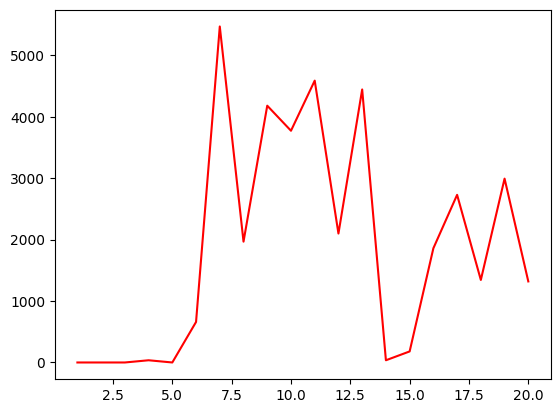

MAE: 1308.71
MSE: 3586433.88
MAPE: inf
    Demand  Forecast   Error
0      0.0       NaN     NaN
1      0.0       NaN     NaN
2      0.0       NaN     NaN
3     36.0       0.0    36.0
4      0.0      12.0   -12.0
5    660.0      12.0   648.0
6   5472.0     232.0  5240.0
7   1968.0    2044.0   -76.0
8   4182.0    2700.0  1482.0
9   3774.0    3874.0  -100.0
10  4590.0    3308.0  1282.0
11  2100.0    4182.0 -2082.0
12  4446.0    3488.0   958.0
13    36.0    3712.0 -3676.0
14   180.0    2194.0 -2014.0
15  1860.0    1554.0   306.0
16  2730.0     692.0  2038.0
17  1344.0    1590.0  -246.0
18  2994.0    1978.0  1016.0
19  1320.0    2356.0 -1036.0
20     NaN    1886.0     NaN
21     NaN    4043.0     NaN
22     NaN    4284.5     NaN
23     NaN    3404.5     NaN
MAE: 1236.72
MSE: 3166556.72
MAPE: inf
    Demand     Forecast        Error
0      0.0          NaN          NaN
1      0.0     0.000000     0.000000
2      0.0     0.000000     0.000000
3     36.0     0.000000    36.000000
4      0.0  

In [ ]:
# productID: 33
demand = np.array([0,0,0,36,0,660,5472,1968,4182,3774,4590,2100,4446,36,180,1860,2730,1344,2994,1320])
plt.plot(period, demand, c = 'r')
plt.show()

df = moving_average(demand)
KPI(df)
print(df)
df = exp_smooth(demand)
KPI(df)
print(df)
df = seasonal_ES(demand)
KPI(df)
print(df)
df = holtWinter(demand)
KPI(df)

df_33 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_33['PeriodSqr'] = df_33['Period'] ** 2
df_33['Quarter'] = qtr
indep = df_33[['Period', 'PeriodSqr', 'Quarter']]
indep = sm.add_constant(indep)
model_33 = sm.OLS(df_33[['Order_Demand']], indep)
result_33 = model_33.fit()
print(result_33.summary())

indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'PeriodSqr': periodSqr_fore, 'Quarter': qtr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_33.predict(indep_fore)
print(indep_fore)

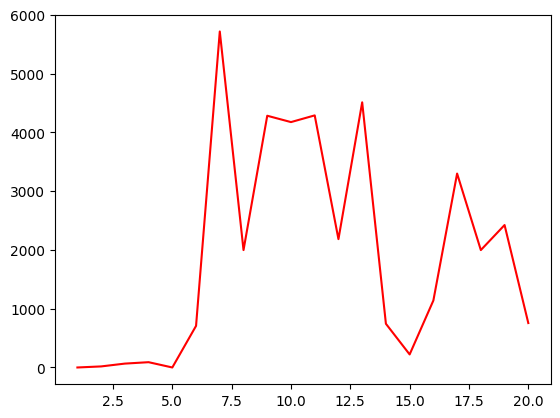

MAE: 1344.47
MSE: 3685022.59
MAPE: inf
    Demand  Forecast   Error
0      0.0       NaN     NaN
1     18.0       NaN     NaN
2     66.0       NaN     NaN
3     90.0      28.0    62.0
4      0.0      58.0   -58.0
5    708.0      52.0   656.0
6   5718.0     266.0  5452.0
7   1998.0    2142.0  -144.0
8   4284.0    2808.0  1476.0
9   4176.0    4000.0   176.0
10  4290.0    3486.0   804.0
11  2184.0    4250.0 -2066.0
12  4512.0    3550.0   962.0
13   744.0    3662.0 -2918.0
14   222.0    2480.0 -2258.0
15  1140.0    1826.0  -686.0
16  3300.0     702.0  2598.0
17  1998.0    1554.0   444.0
18  2424.0    2146.0   278.0
19   756.0    2574.0 -1818.0
20     NaN    1726.0     NaN
21     NaN    3316.0     NaN
22     NaN    3277.0     NaN
23     NaN    2773.0     NaN
MAE: 1220.12
MSE: 3181757.84
MAPE: inf
    Demand     Forecast        Error
0      0.0          NaN          NaN
1     18.0     0.000000    18.000000
2     66.0     7.200000    58.800000
3     90.0    30.720000    59.280000
4      0.0  

In [ ]:
# productID: 34
demand = np.array([0,18,66,90,0,708,5718,1998,4284,4176,4290,2184,4512,744,222,1140,3300,1998,2424,756])
plt.plot(period, demand, c = 'r')
plt.show()

df = moving_average(demand)
KPI(df)
print(df)
df = exp_smooth(demand)
KPI(df)
print(df)
df = seasonal_ES(demand)
KPI(df)
print(df)
df = holtWinter(demand)
KPI(df)

df_34 = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand})
df_34['PeriodSqr'] = df_34['Period'] ** 2
df_34['Quarter'] = qtr
indep = df_34[['Period', 'PeriodSqr', 'Quarter']]
indep = sm.add_constant(indep)
model_34 = sm.OLS(df_34[['Order_Demand']], indep)
result_34 = model_34.fit()
print(result_34.summary())

indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'PeriodSqr': periodSqr_fore, 'Quarter': qtr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_34.predict(indep_fore)
print(indep_fore)

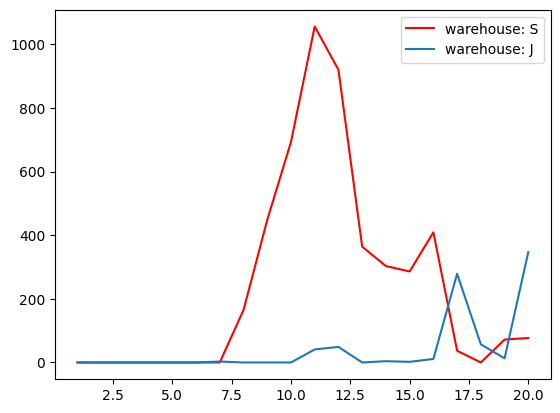

MAE: 226.41
MSE: 92155.68
MAPE: inf
    Demand    Forecast       Error
0      0.0         NaN         NaN
1      0.0         NaN         NaN
2      0.0         NaN         NaN
3      0.0    0.000000    0.000000
4      0.0    0.000000    0.000000
5      0.0    0.000000    0.000000
6      0.0    0.000000    0.000000
7    165.0    0.000000  165.000000
8    448.0   55.000000  393.000000
9    693.0  204.333333  488.666667
10  1056.0  435.333333  620.666667
11   920.0  732.333333  187.666667
12   364.0  889.666667 -525.666667
13   303.0  780.000000 -477.000000
14   286.0  529.000000 -243.000000
15   409.0  317.666667   91.333333
16    37.0  332.666667 -295.666667
17     0.0  244.000000 -244.000000
18    72.0  148.666667  -76.666667
19    77.0   36.333333   40.666667
20     NaN   49.666667         NaN
21     NaN  124.166667         NaN
22     NaN  163.916667         NaN
23     NaN  112.583333         NaN
MAE: 188.91
MSE: 73130.37
MAPE: inf
    Demand    Forecast       Error
0      0.0        

In [ ]:
# productID: 35
# warehouse: S
demand_35S = np.array([0,0,0,0,0,0,0,165,448,693,1056,920,364,303,286,409,37,0,72,77])
demand_35J = np.array([0,0,0,0,0,0,3,0,0,0,41,49,0,4,2,11,279,57,13,347])
plt.plot(period, demand_35S, c = 'r', label = 'warehouse: S')
plt.plot(period, demand_35J, label = 'warehouse: J')
plt.legend()
plt.show()

df = moving_average(demand_35S)
KPI(df)
print(df)
df = exp_smooth(demand_35S)
KPI(df)
print(df)
df = seasonal_ES(demand_35S)
KPI(df)
print(df)
df = holtWinter(demand_35S)
KPI(df)

df_35S = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_35S})
df_35S['Quarter'] = qtr
indep = df_35S[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_35S = sm.OLS(df_35S[['Order_Demand']], indep)
result_35S = model_35S.fit()
print(result_35S.summary())

In [ ]:
# productID: 35
# warehouse: J
df = moving_average(demand_35J)
KPI(df)
df = exp_smooth(demand_35J)
KPI(df)
print(df)
df = seasonal_ES(demand_35J)
KPI(df)
df = holtWinter(demand_35J)
KPI(df)

df_35J = pd.DataFrame.from_dict({'Period':period, 'Order_Demand':demand_35J})
df_35J['Quarter'] = qtr
indep = df_35J[['Period', 'Quarter']]
indep = sm.add_constant(indep)
model_35J = sm.OLS(df_35J[['Order_Demand']], indep)
result_35J = model_35J.fit()
print(result_35J.summary())

indep_fore = pd.DataFrame.from_dict({'Period': period_fore, 'Quarter': qtr_fore})
indep_fore = sm.add_constant(indep_fore)
indep_fore['Prediction'] = result_35J.predict(indep_fore)
print(indep_fore)

MAE: 47.65
MSE: 8525.25
MAPE: inf
MAE: 43.73
MSE: 8865.35
MAPE: inf
    Demand    Forecast       Error
0      0.0         NaN         NaN
1      0.0    0.000000    0.000000
2      0.0    0.000000    0.000000
3      0.0    0.000000    0.000000
4      0.0    0.000000    0.000000
5      0.0    0.000000    0.000000
6      3.0    0.000000    3.000000
7      0.0    1.200000   -1.200000
8      0.0    0.720000   -0.720000
9      0.0    0.432000   -0.432000
10    41.0    0.259200   40.740800
11    49.0   16.555520   32.444480
12     0.0   29.533312  -29.533312
13     4.0   17.719987  -13.719987
14     2.0   12.231992  -10.231992
15    11.0    8.139195    2.860805
16   279.0    9.283517  269.716483
17    57.0  117.170110  -60.170110
18    13.0   93.102066  -80.102066
19   347.0   61.061240  285.938760
20     NaN  175.436744         NaN
21     NaN  175.436744         NaN
22     NaN  175.436744         NaN
23     NaN  175.436744         NaN
MAE: 53.00
MSE: 10811.92
MAPE: inf
MAE: 54.48
MSE: 9928.6

##決策最佳化的程式碼：

In [ ]:
uploaded = files.upload()
# please upload "prediction.csv"

Saving prediction3.csv to prediction3 (1).csv


In [ ]:
data = pd.read_csv(next(iter(uploaded)))
print(data)

    ProductID Warehouse  Cost  Price  MaterialA(g/product)  2017Q1  2017Q2  \
0           1         A   600    720                    66    3254    3276   
1           2         J   553    664                    75    1493    1477   
2           2         S   553    664                    75    1489    1472   
3           3         J   620    744                    73    3317    3352   
4           4         S   623    697                    66    2219    2266   
5           5         S   619    843                    69    1830    1816   
6           5         A   619    843                    69    2742    2715   
7           6         S   480    576                    55    6248    6323   
8           7         J   464    557                    48    7090    7332   
9           8         S   443    532                    53    8408    9101   
10          9         A   450    540                    47    6358    6179   
11         10         J   400    548                    54   117

In [ ]:
price = data['Price'].values
cost = data['Cost'].values
material = data['MaterialA(g/product)'].values
demandQ1 = data['2017Q1'].values
demandQ2 = data['2017Q2'].values
demandQ3 = data['2017Q3'].values
demandQ4 = data['2017Q4'].values

print(price)
print(cost)
print(material)
print(demandQ1)
print(demandQ2)
print(demandQ3)
print(demandQ4)

[ 720  664  664  744  697  843  843  576  557  532  540  548  258  253
  253  240  215  120  190  145   86   60  225  197  185  215  145  435
  435  333  360  360  477  477 1094 1094 1094  960  940  928  974  974]
[600 553 553 620 623 619 619 480 464 443 450 400 215 224 211 200 179 100
 140 121  72  50 189 169 150 126 123 350 350 294 250 314 324 324 765 765
 765 800 783 773 827 827]
[66 75 75 73 66 69 69 55 48 53 47 54 24 19 16 19 24 14  6 13 14 15 19 19
 22 16 18 44 44 36 41 35 39 39 92 92 92 90 93 93 95 95]
[  3254   1493   1489   3317   2219   1830   2742   6248   7090   8408
   6358  11719  28713  10241  11729  19733  21833  29021  34767  22433
  21633  26667  12880  29625  35277 459862  15333  14830   5727  25015
  74752  24200  65710  77500    394    410    278    169   1881   1641
    104    175]
[  3276   1477   1472   3352   2266   1816   2715   6323   7332   9101
   6179  12246  21922   4770  28941  19811  21611  28802  35589  23144
  21711  25689  11153  29625  40569 459862 

In [ ]:
I = 42
x0 = np.zeros(I)

In [ ]:
def objectiveQ1(x):
    # 計算總收入
    revenueQ1 = sum(price[i] * min(x[i], demandQ1[i]) for i in range(I))

    # 計算總成本
    total_costQ1 = sum(cost[i] * x[i] for i in range(I))+sum(price[i] * 0.1 * max(x[i]-demandQ1[i], 0) for i in range(I))

    # 目標函數為總收入減去總成本
    objQ1 = revenueQ1 - total_costQ1

    return -objQ1

def objectiveQ2(x):
    # 計算總收入
    revenueQ2 = sum(price[i] * min(x[i], demandQ2[i]) for i in range(I))

    # 計算總成本
    total_costQ2 = sum(cost[i] * x[i] for i in range(I))+sum(price[i] * 0.1 * max(x[i]-demandQ2[i], 0) for i in range(I))

    # 目標函數為總收入減去總成本
    objQ2 = revenueQ2 - total_costQ2

    return -objQ2

def objectiveQ3(x):
    # 計算總收入
    revenueQ3 = sum(price[i] * min(x[i], demandQ3[i]) for i in range(I))

    # 計算總成本
    total_costQ3 = sum(cost[i] * x[i] for i in range(I))+sum(price[i] * 0.1 * max(x[i]-demandQ3[i], 0) for i in range(I))

    # 目標函數為總收入減去總成本
    objQ3 = revenueQ3 - total_costQ3

    return -objQ3

def objectiveQ4(x):
    # 計算總收入
    revenueQ4 = sum(price[i] * min(x[i], demandQ4[i]) for i in range(I))

    # 計算總成本
    total_costQ4 = sum(cost[i] * x[i] for i in range(I))+sum(price[i] * 0.1 * max(x[i]-demandQ4[i], 0) for i in range(I))

    # 目標函數為總收入減去總成本
    objQ4 = revenueQ4 - total_costQ4

    return -objQ4

In [ ]:
def constraint1(x):
  return 25000 * 1000 - sum(material[i] * x[i] for i in range(I))

def constraint2(x):
  return 24000 - (sum(x[0:7]))

def constraint3(x):
  return 80000 - (sum(x[7:12]))

def constraint4(x):
  return 150000 - (sum(x[12:17]))

def constraint5(x):
  return 162000 - (sum(x[17:22]))

def constraint6(x):
  return 612000 - (sum(x[22:27]))

def constraint7(x):
  return 408000 - (sum(x[27:34]))

def constraint8(x):
  return 9000 - (sum(x[34:42]))

def constraint9(x):
  return x - 1000

def constraint10(x):
  return x[1] + x[2] - 1000

def constraint11(x):
  return x[5] + x[6] - 1000

def constraint12(x):
  return x[27] + x[28] - 1000

def constraint13(x):
  return x[32] + x[33] - 1000

def constraint14(x):
  return x

def constraint15(x):
  return 110000 - (x[0]+x[6]+x[10]+x[17]+x[20]+x[27]+x[35]+x[38]+x[39])

def constraint16(x):
  return 235000 - (x[12]+x[13]+x[14]+x[15]+x[16]+x[32])

def constraint17(x):
  return 1715000 - (x[1]+x[3]+x[8]+x[11]+x[18]+x[21]+x[22]+x[23]+x[24]+x[25]+x[26]+x[28]+x[29]+x[30]+x[31]+x[33]+x[36]+x[41])

def constraint18(x):
  return 60000 - (x[2]+x[4]+x[5]+x[7]+x[9]+x[19]+x[34]+x[37]+x[40])

In [ ]:
constraints = [{'type': 'ineq', 'fun': constraint1}] + \
        [{'type': 'ineq', 'fun': constraint2}] + \
        [{'type': 'ineq', 'fun': constraint3}] + \
        [{'type': 'ineq', 'fun': constraint4}] + \
        [{'type': 'ineq', 'fun': constraint5}] + \
        [{'type': 'ineq', 'fun': constraint6}] + \
        [{'type': 'ineq', 'fun': constraint7}] + \
        [{'type': 'ineq', 'fun': constraint8}] + \
        [{'type': 'ineq', 'fun': constraint9} for _ in range(0,1)] + \
        [{'type': 'ineq', 'fun': constraint10}] + \
        [{'type': 'ineq', 'fun': constraint9} for _ in range(3,5)] + \
        [{'type': 'ineq', 'fun': constraint11}] + \
        [{'type': 'ineq', 'fun': constraint9} for _ in range(7, 12)] + \
        [{'type': 'ineq', 'fun': constraint9} for _ in range(12, 17)] + \
        [{'type': 'ineq', 'fun': constraint9} for _ in range(17, 22)] + \
        [{'type': 'ineq', 'fun': constraint9} for _ in range(22, 27)] + \
        [{'type': 'ineq', 'fun': constraint12}] + \
        [{'type': 'ineq', 'fun': constraint9} for _ in range(29, 32)] + \
        [{'type': 'ineq', 'fun': constraint13}] + \
        [{'type': 'ineq', 'fun': constraint14} for _ in range(34, 42)] + \
        [{'type': 'ineq', 'fun': constraint15}] + \
        [{'type': 'ineq', 'fun': constraint16}] + \
        [{'type': 'ineq', 'fun': constraint17}] + \
        [{'type': 'ineq', 'fun': constraint18}]

In [ ]:
resQ1 = opt.minimize(objectiveQ1,x0,constraints=constraints,options={'maxiter': 10000})
print(resQ1)
for i in range(I):
    print(resQ1.x[i])
print(-resQ1.fun)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -84421695.98645172
       x: [ 3.254e+03  1.493e+03 ...  1.000e+03  1.000e+03]
     nit: 586
     jac: [-1.200e+02 -1.120e+02 ...  9.220e+02  9.220e+02]
    nfev: 25989
    njev: 584
3253.931464005986
1492.5620238913264
1488.1157988682244
3316.9928905626
1000.0124479908274
1829.9997021229992
2741.9990206760817
6247.9999998887915
7089.987941478629
8407.410135272716
6357.732235294285
11718.99998694768
28676.57417140926
10234.371928701372
11729.012880085937
19732.458026560613
12287.283279238467
1619.5460549647157
34767.01611414623
7299.723109847035
2062.7971527072987
1002.5668413893532
12845.669235498679
9290.660131452936
35196.50918446484
459861.9818843229
2499.6702765521277
14830.007079945335
5726.638537154638
10181.496977077608
74751.96986708404
11797.942274492885
65710.00361064545
77499.99342963086
1000.0000032037361
1000.0000058212612
1000.0000041626286
1000.0000013753563
1703.801684556309
1295.729847

In [ ]:
resQ2 = opt.minimize(objectiveQ2,x0,constraints=constraints,options={'maxiter': 10000})
print(resQ2)
for i in range(I):
    print(resQ2.x[i])
print(-resQ2.fun)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -86956493.39117357
       x: [ 3.276e+03  1.000e+03 ...  1.000e+03  1.000e+03]
     nit: 688
     jac: [-1.200e+02 -1.120e+02 ...  9.260e+02  9.260e+02]
    nfev: 30855
    njev: 684
3275.9354426768737
1000.1245201419473
1000.1245124814415
1428.7956855683465
1000.0010431012973
1816.0008401255604
2715.0056846088655
6323.0022584829685
7331.185959316224
3219.9228613878777
6178.998711019797
12246.002525093667
11349.0889499169
1052.820964414991
28902.961929514968
19809.2216428267
3224.6617704205028
1000.0006113491349
35589.06312456128
10210.584739296115
6981.198229439065
1490.9245385140857
11153.005886069886
9151.948089908383
26158.75620710795
459861.94309299096
10760.221601776513
7856.804937285931
5269.1979366482465
1124.9071396676532
109420.99995948731
18030.56475294065
65709.98673651097
77499.97337777168
1000.0019529163923
1000.0039480930268
1000.0024372080563
999.999999944742
1692.3724314091492
1001.3995

In [ ]:
resQ3 = opt.minimize(objectiveQ3,x0,constraints=constraints,options={'maxiter': 10000})
print(resQ3)
for i in range(I):
    print(resQ3.x[i])
print(-resQ3.fun)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -86805760.494638
       x: [ 3.278e+03  1.689e+03 ...  1.000e+03  1.000e+03]
     nit: 960
     jac: [ 6.720e+02 -1.100e+02 ...  9.240e+02  9.240e+02]
    nfev: 42674
    njev: 958
3278.00862394489
1688.5371285065794
1591.2571598934705
3435.954676886105
1000.0089870592777
2102.0035969565065
3145.989134124548
6478.995302642929
7510.999741599571
7807.5705190378485
6069.883054405273
12069.99063457179
14132.55890332397
1000.0125545802538
20209.993670606105
19481.02650117549
1279.5035639121138
11951.314104209156
35519.000739055846
13272.98059412289
1000.5425800483803
1000.0635138867176
9261.999999030735
1000.0039322298778
14282.19316941847
459862.00516486913
10494.790086052722
12574.07185451885
5341.903255832295
1556.8615137588167
100284.00837740612
19852.40871811839
65709.99294061029
77499.96328925974
1254.994700521299
1000.0000095411294
1000.0001847382389
1000.0000017215012
1488.444357156537
1256.200161562

In [ ]:
resQ4 = opt.minimize(objectiveQ4,x0,constraints=constraints,options={'maxiter': 10000})
print(resQ4)
for i in range(I):
    print(resQ4.x[i])
print(-resQ4.fun)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -86924071.19176811
       x: [ 3.269e+03  1.614e+03 ...  1.000e+03  1.000e+03]
     nit: 1039
     jac: [-1.200e+02 -1.100e+02 ...  9.240e+02  9.260e+02]
    nfev: 46705
    njev: 1036
3268.9980657692536
1614.1132276647245
1695.9996192463586
3511.999475980908
1000.0000000425182
1934.0301428827354
2883.9835838256877
6298.999651859978
7678.7992026839365
1515.158920071636
6201.999958984511
12012.054315860023
31964.77843617961
1000.0000008295749
24880.355255136175
19674.99986381791
4088.3566911536436
1000.0000044381467
35291.97505662235
20863.12683360331
1153.332358335444
3877.4847097718703
7206.859399407746
1103.5120661255887
1080.5261503285426
459862.1220778453
6229.470571737737
7918.039330446132
5376.0002189103925
1026.6611054497728
109756.99977661556
22181.436376349007
65709.92160132881
77499.9892393649
1000.0003571695169
1000.0008717379435
1000.0000281141342
1000.0000001012696
1388.0009171289241
1054.5